In [3]:
# from pyspark.sql.functions import *
from pyspark.sql.session import SparkSession
# from pyspark.sql.functions import when, isnull, col, date_format, avg
from pyspark.ml.feature import StringIndexer
from pyspark.sql import functions as F
# import torch
# import torch.nn as nn

sc = F.SparkContext.getOrCreate()
spark = SparkSession(sc)

### Starting Apache Hadoop

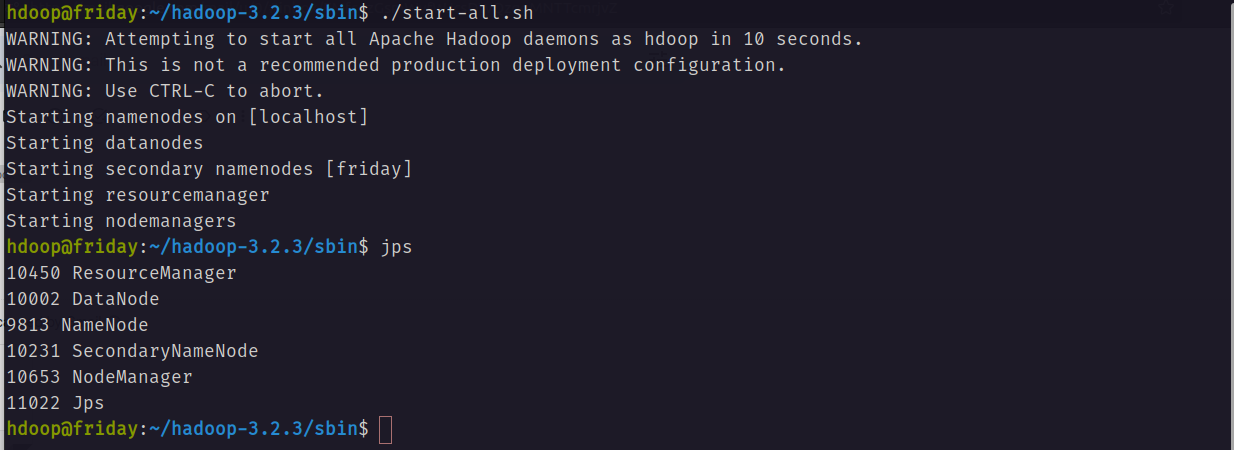

### Adding dataset into hadoop distributed file system (hdfs)

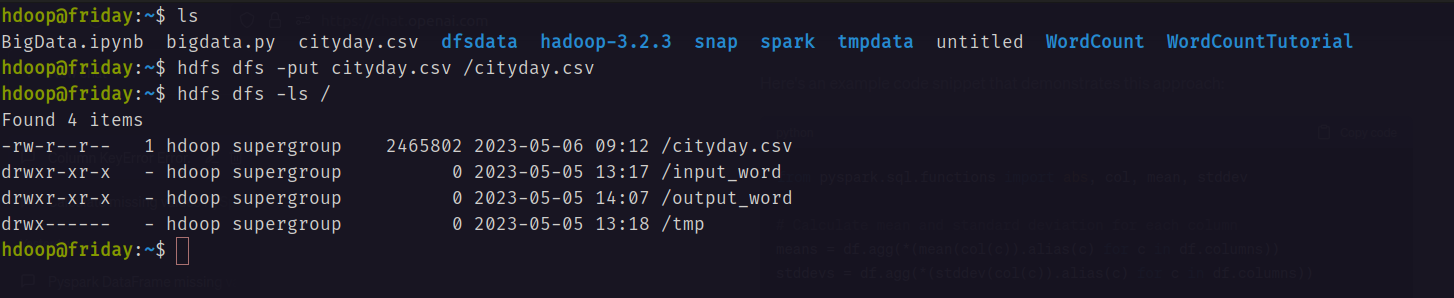

### Running pyspark

Here jupyter notebook is set to run pyspark gets executed

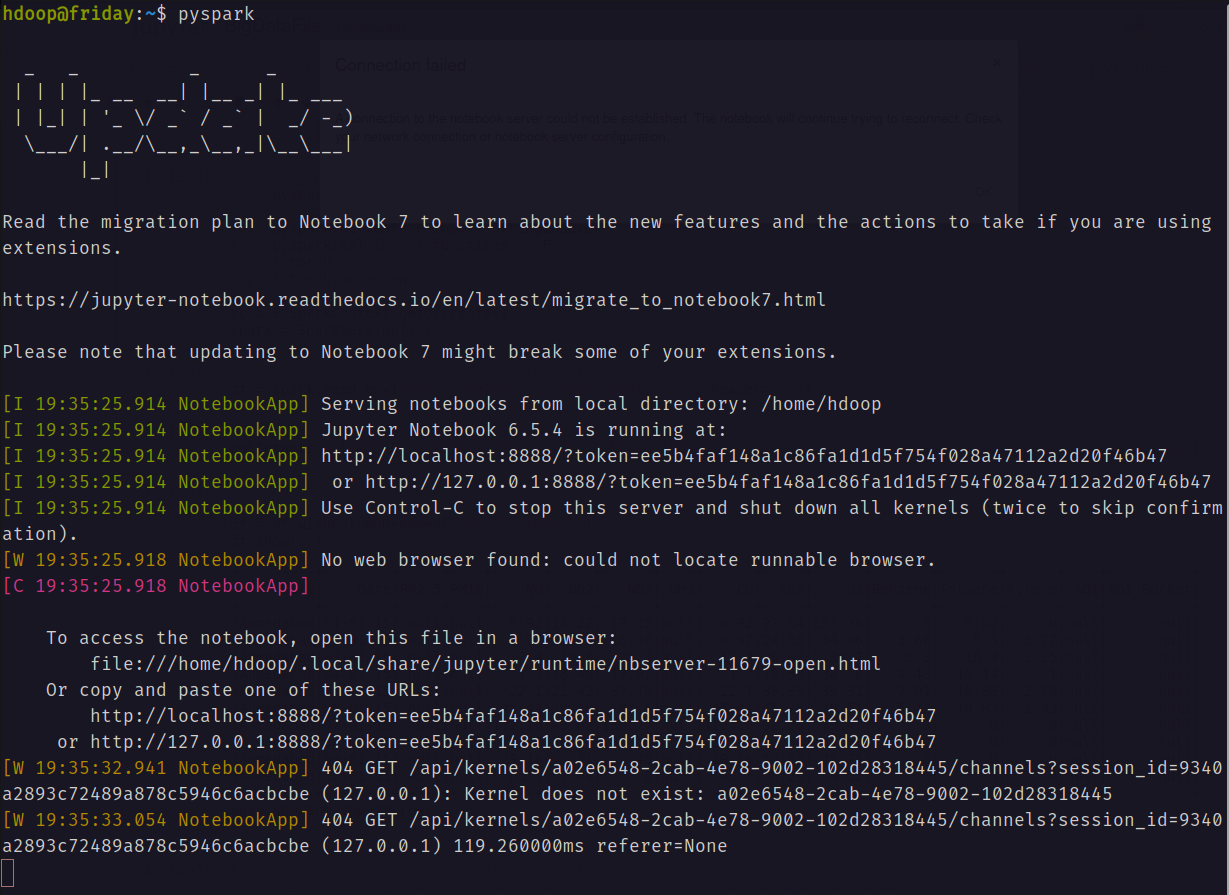

In [5]:
# read csv file from hadoop filesystem(hdfs)
df = spark.read.csv("hdfs://127.0.0.1:9000/cityday.csv", header=True)

In [203]:
# Columns that contains data about air pollutants in the dataset
pollutants = ['PM2_5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI']

In [204]:
# thePM2.5 column is renamed to PM2_5 since the decimal gave problems during queries

df = df.withColumnRenamed("PM2.5", "PM2_5")
df.show(10)

+---------+--------+-----+----+------+-----+------+----+------+-----+------+-------+-------+------+----+----------+
|     City|    Date|PM2_5|PM10|    NO|  NO2|   NOx| NH3|    CO|  SO2|    O3|Benzene|Toluene|Xylene| AQI|AQI_Bucket|
+---------+--------+-----+----+------+-----+------+----+------+-----+------+-------+-------+------+----+----------+
|Ahmedabad|01-01-15| null|null|  0.92|18.22| 17.15|null|  0.92|27.64|133.36|      0|   0.02|     0|null|      null|
|Ahmedabad|02-01-15| null|null|  0.97|15.69| 16.46|null|  0.97|24.55| 34.06|   3.68|    5.5|  3.77|null|      null|
|Ahmedabad|03-01-15| null|null|  17.4| 19.3|  29.7|null|  17.4|29.07|  30.7|    6.8|   16.4|  2.25|null|      null|
|Ahmedabad|04-01-15| null|null|   1.7|18.48| 17.97|null|   1.7|18.59| 36.08|   4.43|  10.14|     1|null|      null|
|Ahmedabad|05-01-15| null|null|  22.1|21.42| 37.76|null|  22.1|39.33| 39.31|   7.01|  18.89|  2.78|null|      null|
|Ahmedabad|06-01-15| null|null| 45.41|38.48|  81.5|null| 45.41|45.76| 46

In [205]:
# converting records in Date Column to Date Type
# this is done to extract the year from the records and create a seperate column

df = df.withColumn('Date', F.to_date('Date', 'dd-MM-yy'))
df = df.withColumn('year', F.year('Date'))

df.show(10)

+---------+----------+-----+----+------+-----+------+----+------+-----+------+-------+-------+------+----+----------+----+
|     City|      Date|PM2_5|PM10|    NO|  NO2|   NOx| NH3|    CO|  SO2|    O3|Benzene|Toluene|Xylene| AQI|AQI_Bucket|year|
+---------+----------+-----+----+------+-----+------+----+------+-----+------+-------+-------+------+----+----------+----+
|Ahmedabad|2015-01-01| null|null|  0.92|18.22| 17.15|null|  0.92|27.64|133.36|      0|   0.02|     0|null|      null|2015|
|Ahmedabad|2015-01-02| null|null|  0.97|15.69| 16.46|null|  0.97|24.55| 34.06|   3.68|    5.5|  3.77|null|      null|2015|
|Ahmedabad|2015-01-03| null|null|  17.4| 19.3|  29.7|null|  17.4|29.07|  30.7|    6.8|   16.4|  2.25|null|      null|2015|
|Ahmedabad|2015-01-04| null|null|   1.7|18.48| 17.97|null|   1.7|18.59| 36.08|   4.43|  10.14|     1|null|      null|2015|
|Ahmedabad|2015-01-05| null|null|  22.1|21.42| 37.76|null|  22.1|39.33| 39.31|   7.01|  18.89|  2.78|null|      null|2015|
|Ahmedabad|2015-

In [206]:
# here we can see the missing values for each column
missing_values = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values.show()

+----+----+-----+-----+----+----+----+-----+----+----+----+-------+-------+------+----+----------+----+
|City|Date|PM2_5| PM10|  NO| NO2| NOx|  NH3|  CO| SO2|  O3|Benzene|Toluene|Xylene| AQI|AQI_Bucket|year|
+----+----+-----+-----+----+----+----+-----+----+----+----+-------+-------+------+----+----------+----+
|   0|   0| 4598|11140|3582|3585|4185|10328|2059|3854|4022|   5623|   8041| 18109|4681|      4681|   0|
+----+----+-----+-----+----+----+----+-----+----+----+----+-------+-------+------+----+----------+----+



In [207]:
# percentage of missing values is also calculated
total_count = df.count()
missing_percentages = missing_values.select([F.round((missing_values[c] / total_count * 100), 2).alias(c) for c in missing_values.columns])
missing_percentages.show()

+----+----+-----+-----+-----+-----+-----+-----+----+-----+-----+-------+-------+------+-----+----------+----+
|City|Date|PM2_5| PM10|   NO|  NO2|  NOx|  NH3|  CO|  SO2|   O3|Benzene|Toluene|Xylene|  AQI|AQI_Bucket|year|
+----+----+-----+-----+-----+-----+-----+-----+----+-----+-----+-------+-------+------+-----+----------+----+
| 0.0| 0.0|15.57|37.72|12.13|12.14|14.17|34.97|6.97|13.05|13.62|  19.04|  27.23| 61.32|15.85|     15.85| 0.0|
+----+----+-----+-----+-----+-----+-----+-----+----+-----+-----+-------+-------+------+-----+----------+----+



In [208]:
import seaborn as sns
import matplotlib.pyplot as plt

In [209]:
df.printSchema()

# convert these features into data type of float
features = ['PM2_5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI']

for column in features:
    df=df.withColumn(column,df[column].cast("float").alias(column))
    
df.printSchema()

root
 |-- City: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- PM2_5: string (nullable = true)
 |-- PM10: string (nullable = true)
 |-- NO: string (nullable = true)
 |-- NO2: string (nullable = true)
 |-- NOx: string (nullable = true)
 |-- NH3: string (nullable = true)
 |-- CO: string (nullable = true)
 |-- SO2: string (nullable = true)
 |-- O3: string (nullable = true)
 |-- Benzene: string (nullable = true)
 |-- Toluene: string (nullable = true)
 |-- Xylene: string (nullable = true)
 |-- AQI: string (nullable = true)
 |-- AQI_Bucket: string (nullable = true)
 |-- year: integer (nullable = true)

root
 |-- City: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- PM2_5: float (nullable = true)
 |-- PM10: float (nullable = true)
 |-- NO: float (nullable = true)
 |-- NO2: float (nullable = true)
 |-- NOx: float (nullable = true)
 |-- NH3: float (nullable = true)
 |-- CO: float (nullable = true)
 |-- SO2: float (nullable = true)
 |-- O3: float (nullable = true

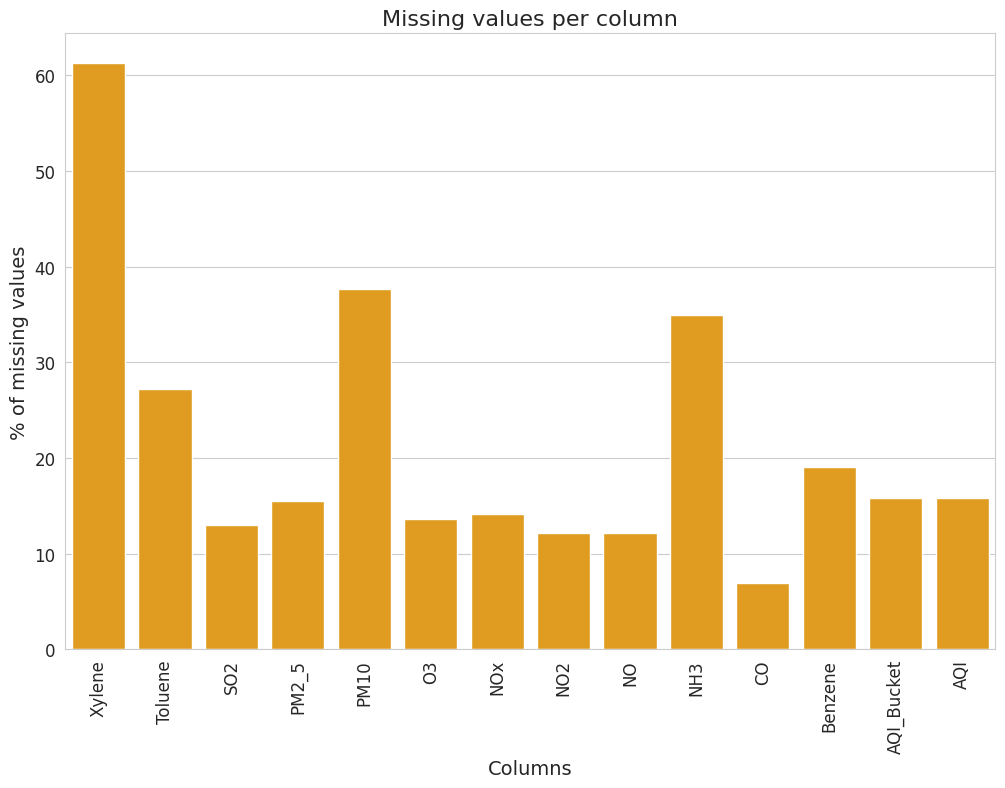

In [210]:
transformed_data = missing_percentages.drop("Date", "City", "year")
transformed_data = transformed_data.toPandas().T.reset_index().rename(columns = {"index": "Pollutant", 0:"Val"})
transformed_data = transformed_data.sort_values("Pollutant", ascending=False).reset_index(drop = True)

# Plot the percentage of missing values for each column
plt.subplots(figsize=(12,8))
sns.barplot(x=transformed_data['Pollutant'], y=transformed_data['Val'], color='orange')
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Columns', fontsize=14)
plt.ylabel('% of missing values', fontsize=14)
plt.title('Missing values per column', fontsize=16)
plt.show()

In [211]:
df1 = df.alias('df1')
df1 = df1.drop("Date","City", "AQI_Bucket", "year")

In [212]:
# Calculating the skewness of each column
skewness_values = df1.select([F.round(F.skewness(c), 2).alias(c) for c in df1.columns])

# Display the skewness for each column
skewness_values.show()

+-----+----+----+----+----+----+----+----+----+-------+-------+------+---+
|PM2_5|PM10|  NO| NO2| NOx| NH3|  CO| SO2|  O3|Benzene|Toluene|Xylene|AQI|
+-----+----+----+----+----+----+----+----+----+-------+-------+------+---+
| 3.37|2.05|3.88|2.46|2.57|4.08|8.88|4.08|1.33|   21.3|  11.67|  7.89|3.4|
+-----+----+----+----+----+----+----+----+----+-------+-------+------+---+



Skewness is a measure of asymmetry in a dataset. A skewness value of 0 indicates that the data is perfectly symmetric, and a positive (or right) skewness value indicates that the data has a longer tail on the right side of the distribution. On the other hand, a negative (or left) skewness value indicates that the data has a longer tail on the left side of the distribution. Based on these skewness values, we can say that the variables PM2.5, NO, NH3, CO, SO2, Benzene, Toluene, Xylene, and AQI are highly positively skewed, which means that these variables have a longer tail on the right side of the distribution. The variables PM10, NO2, and O3 are also positively skewed but to a lesser extent.

Therefore, filling with median value is a possible choice

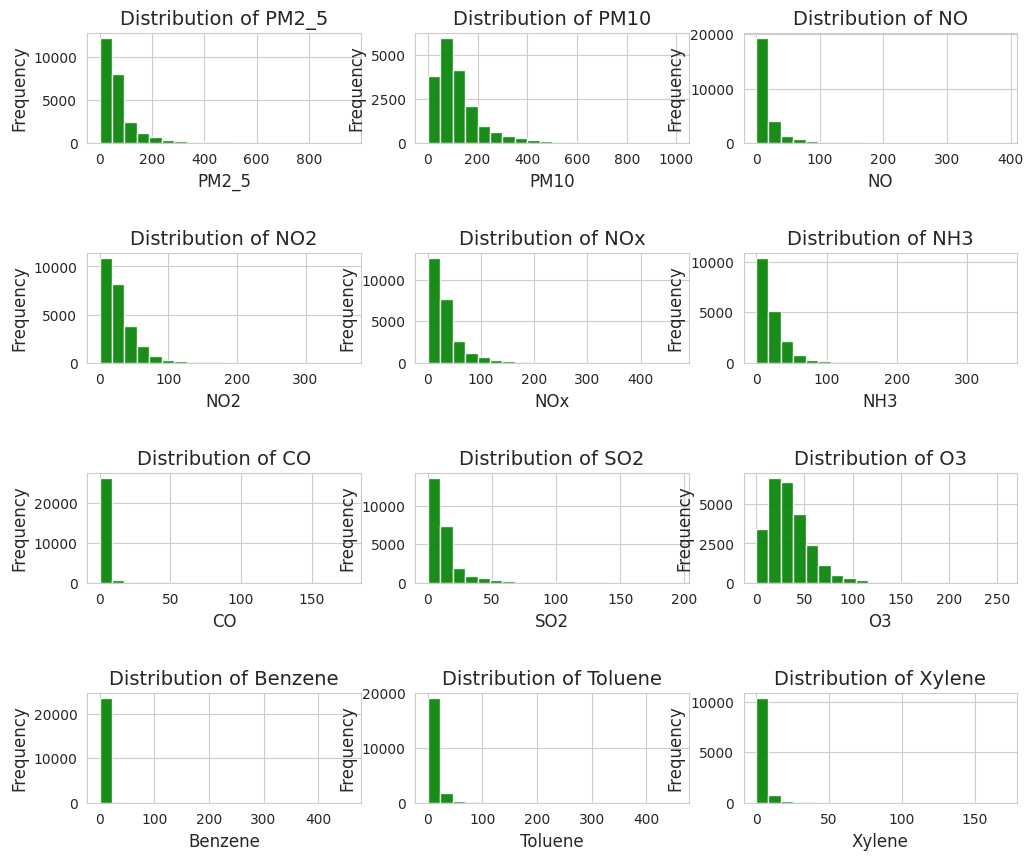

In [213]:
# Set the size of the figure
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 10))
plt.subplots_adjust(hspace=1)

# Create a histogram for each specified variable
features = ['PM2_5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI']
for ax, column in zip(axes.flatten(), features):
    pd_df = df.select(column).toPandas()
    ax.hist(pd_df, bins=20, alpha=0.9, color='green')
    ax.set_xlabel(column, fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)
    ax.set_title("Distribution of " + column, fontsize=14)

# Show the plot
plt.show()

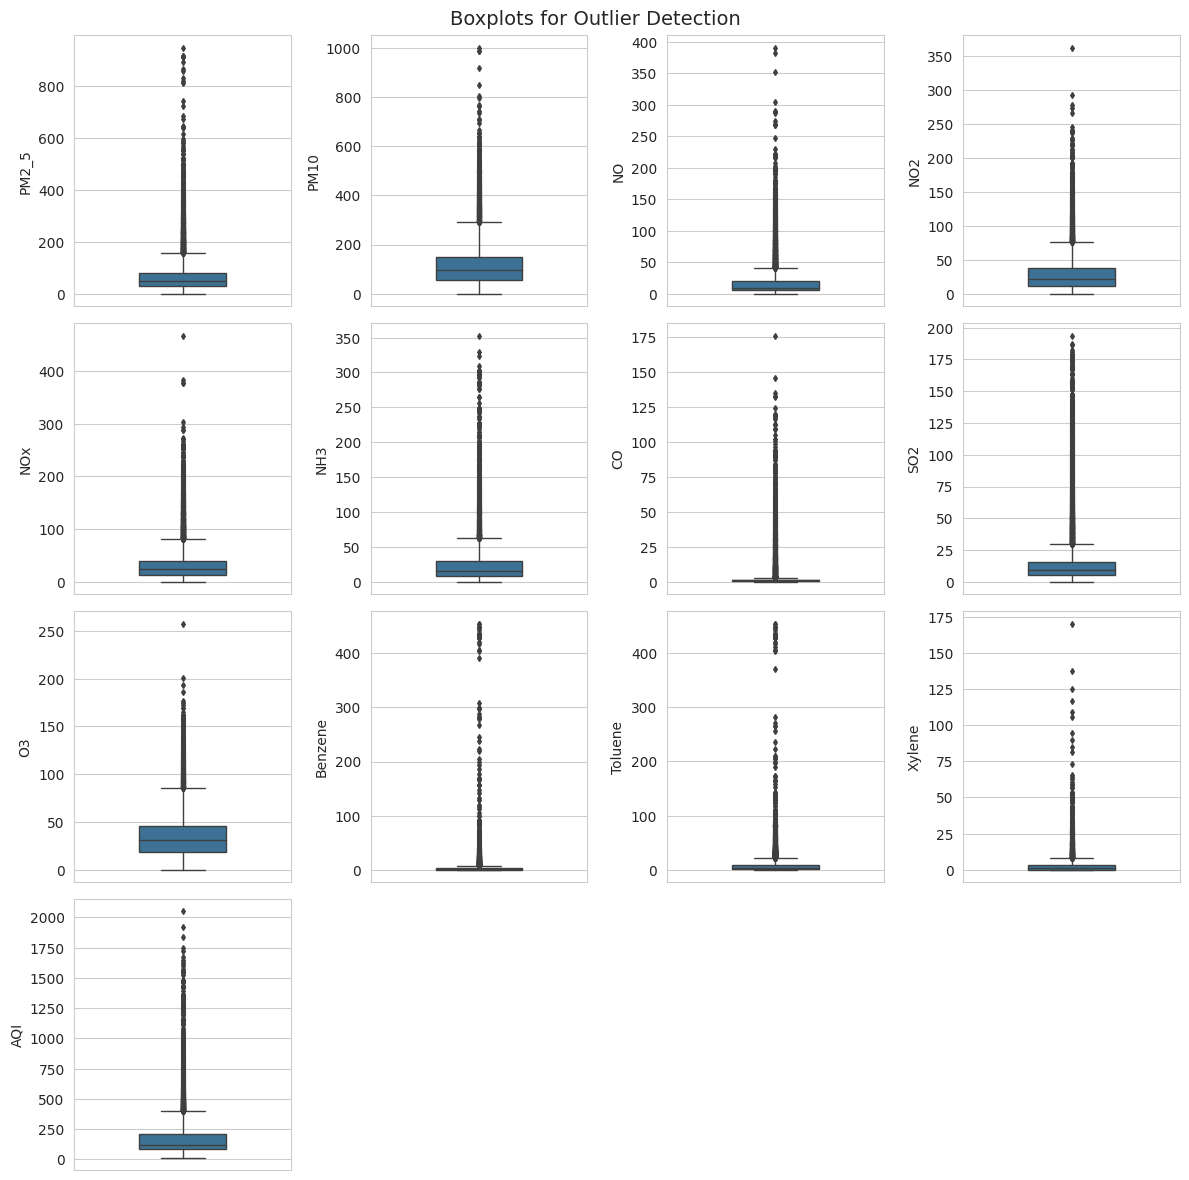

In [214]:
# Select the columns to check for outliers
cols = ['PM2_5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI']

# Create a figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
axes = axes.flatten()

# Loop through each column and create a boxplot
for i, column in enumerate(cols):
    boxplot_data = df.select(column).toPandas()
    sns.boxplot(y=boxplot_data[column], ax=axes[i], width=0.4, fliersize=3, linewidth=1, notch=False, saturation=0.6)
    axes[i].set_xlabel('')
    axes[i].set_ylabel(column, fontsize=10)

# Remove empty subplots
for i in range(len(cols), len(axes)):
    axes[i].remove()

# Add a title to the figure
fig.suptitle('Boxplots for Outlier Detection', fontsize=14)

# Adjust spacing between subplots and save the figure
fig.tight_layout()
plt.savefig('outlier_boxplots.png')
plt.show()

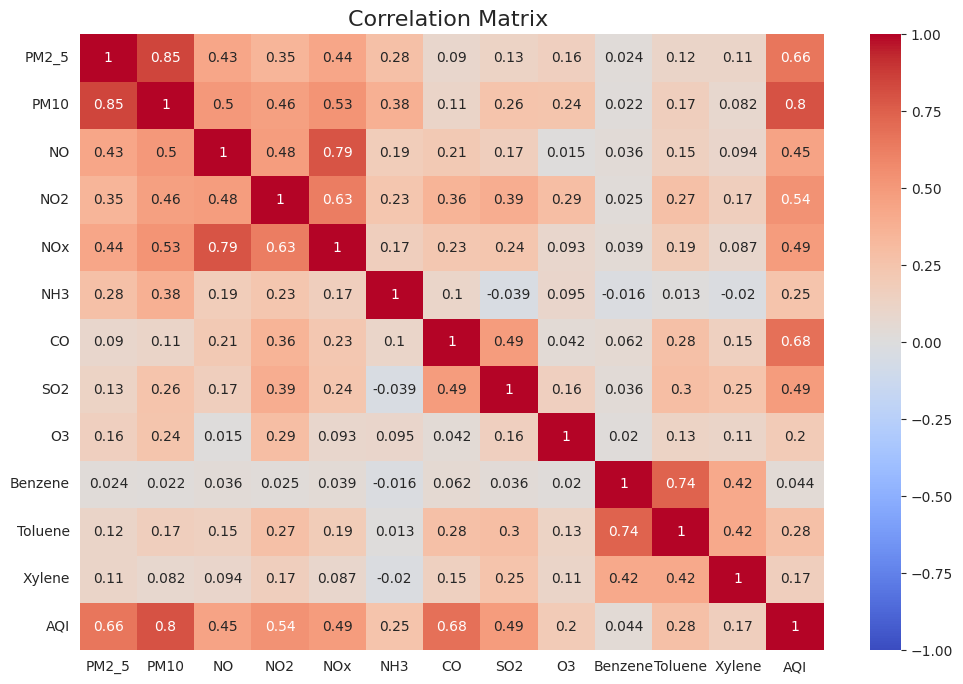

In [215]:
plt.figure(figsize=(12, 8))

# Calculate the correlation matrix
corr = df.drop("City", "Date", "AQI_Bucket", "year").toPandas().corr()

# Plot the correlation matrix
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix ", fontsize=16)
plt.savefig('Corelation.png')
plt.show()

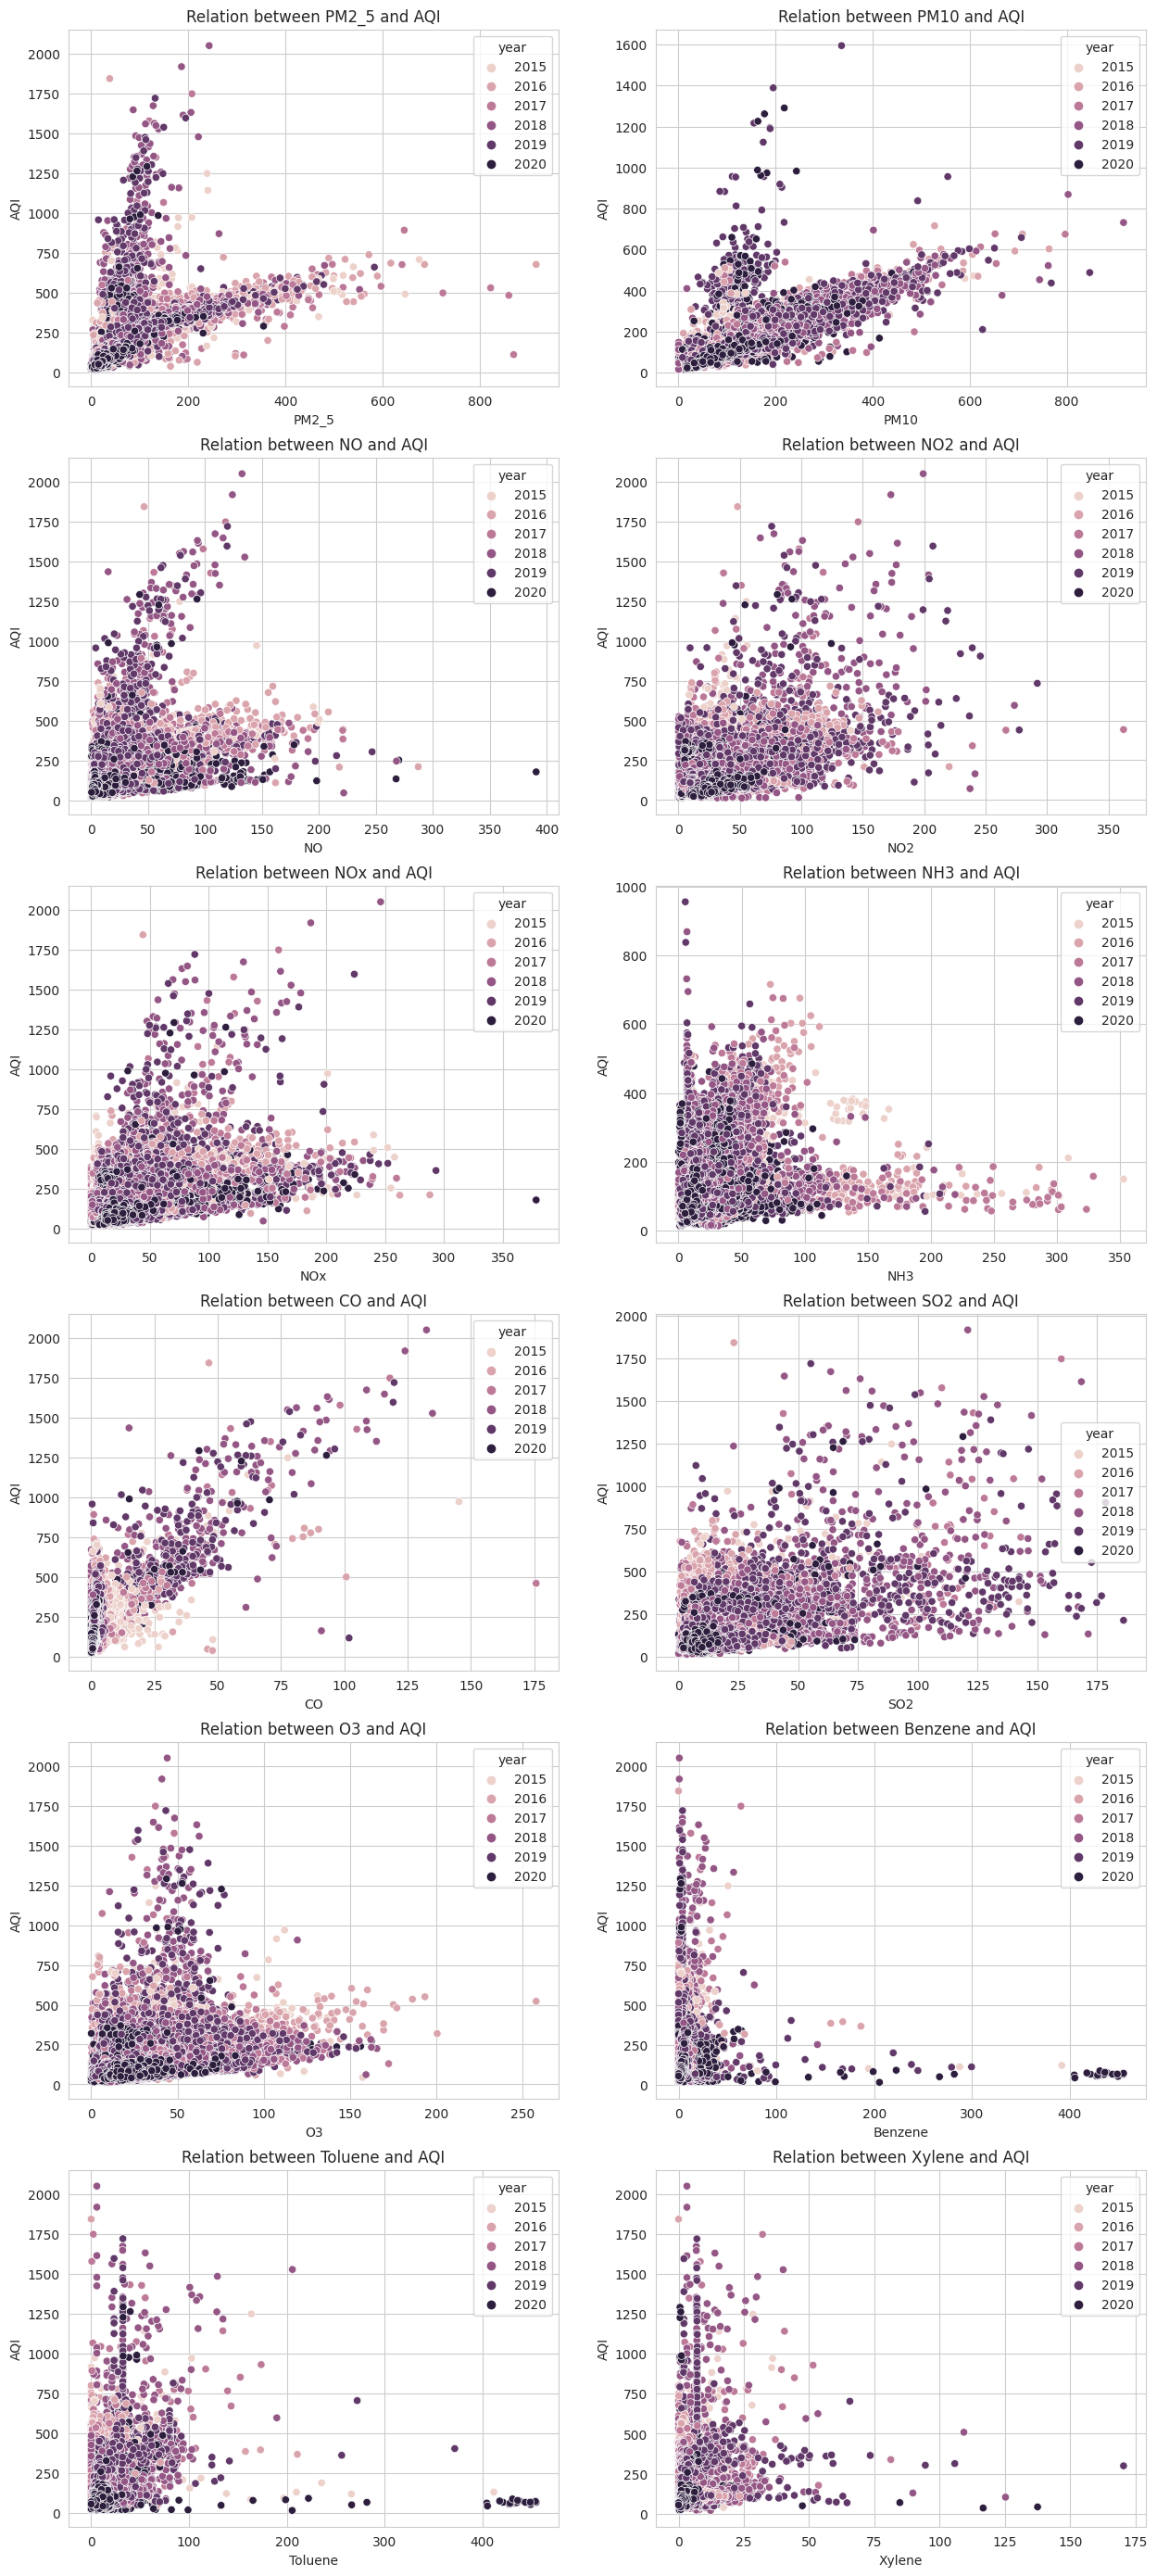

In [216]:
variables = ['PM2_5', 'PM10', 'NO', 'NO2', 'NOx',"NH3",'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']

fig= plt.figure(figsize=(15,35))
for column, num in zip(variables, range(1, len(variables) + 1)):
    ax = fig.add_subplot(6,2,num)
    scatterplot_data = df.toPandas()
    sns.scatterplot(x=column, y='AQI',hue='year', data=scatterplot_data)
    plt.title('Relation between {} and AQI'.format(column))
    plt.xlabel(column)
    plt.ylabel('AQI')

In [217]:
avg_pollution = df.groupBy("City", "year").agg(
F.mean("PM2_5").alias("PM2_5"), 
F.mean("PM10").alias("PM10"),
F.mean("NO").alias("NO"),
F.mean("NO2").alias("NO2"),
F.mean("NOx").alias("NOx"),
F.mean("NH3").alias("NH3"),
F.mean("CO").alias("CO"),
F.mean("SO2").alias("SO2"),
F.mean("O3").alias("O3"),
F.mean("Benzene").alias("Benzene"),
F.mean("Toluene").alias("Toluene"), 
F.mean("Xylene").alias("Xylene"), 
F.mean("AQI").alias("AQI"))

avg_pollution.printSchema()

# avg_pollution = avg_pollution.select(round(''))

# avg_pollution.show()
# avg_pollution.printSchema()

root
 |-- City: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- PM2_5: double (nullable = true)
 |-- PM10: double (nullable = true)
 |-- NO: double (nullable = true)
 |-- NO2: double (nullable = true)
 |-- NOx: double (nullable = true)
 |-- NH3: double (nullable = true)
 |-- CO: double (nullable = true)
 |-- SO2: double (nullable = true)
 |-- O3: double (nullable = true)
 |-- Benzene: double (nullable = true)
 |-- Toluene: double (nullable = true)
 |-- Xylene: double (nullable = true)
 |-- AQI: double (nullable = true)



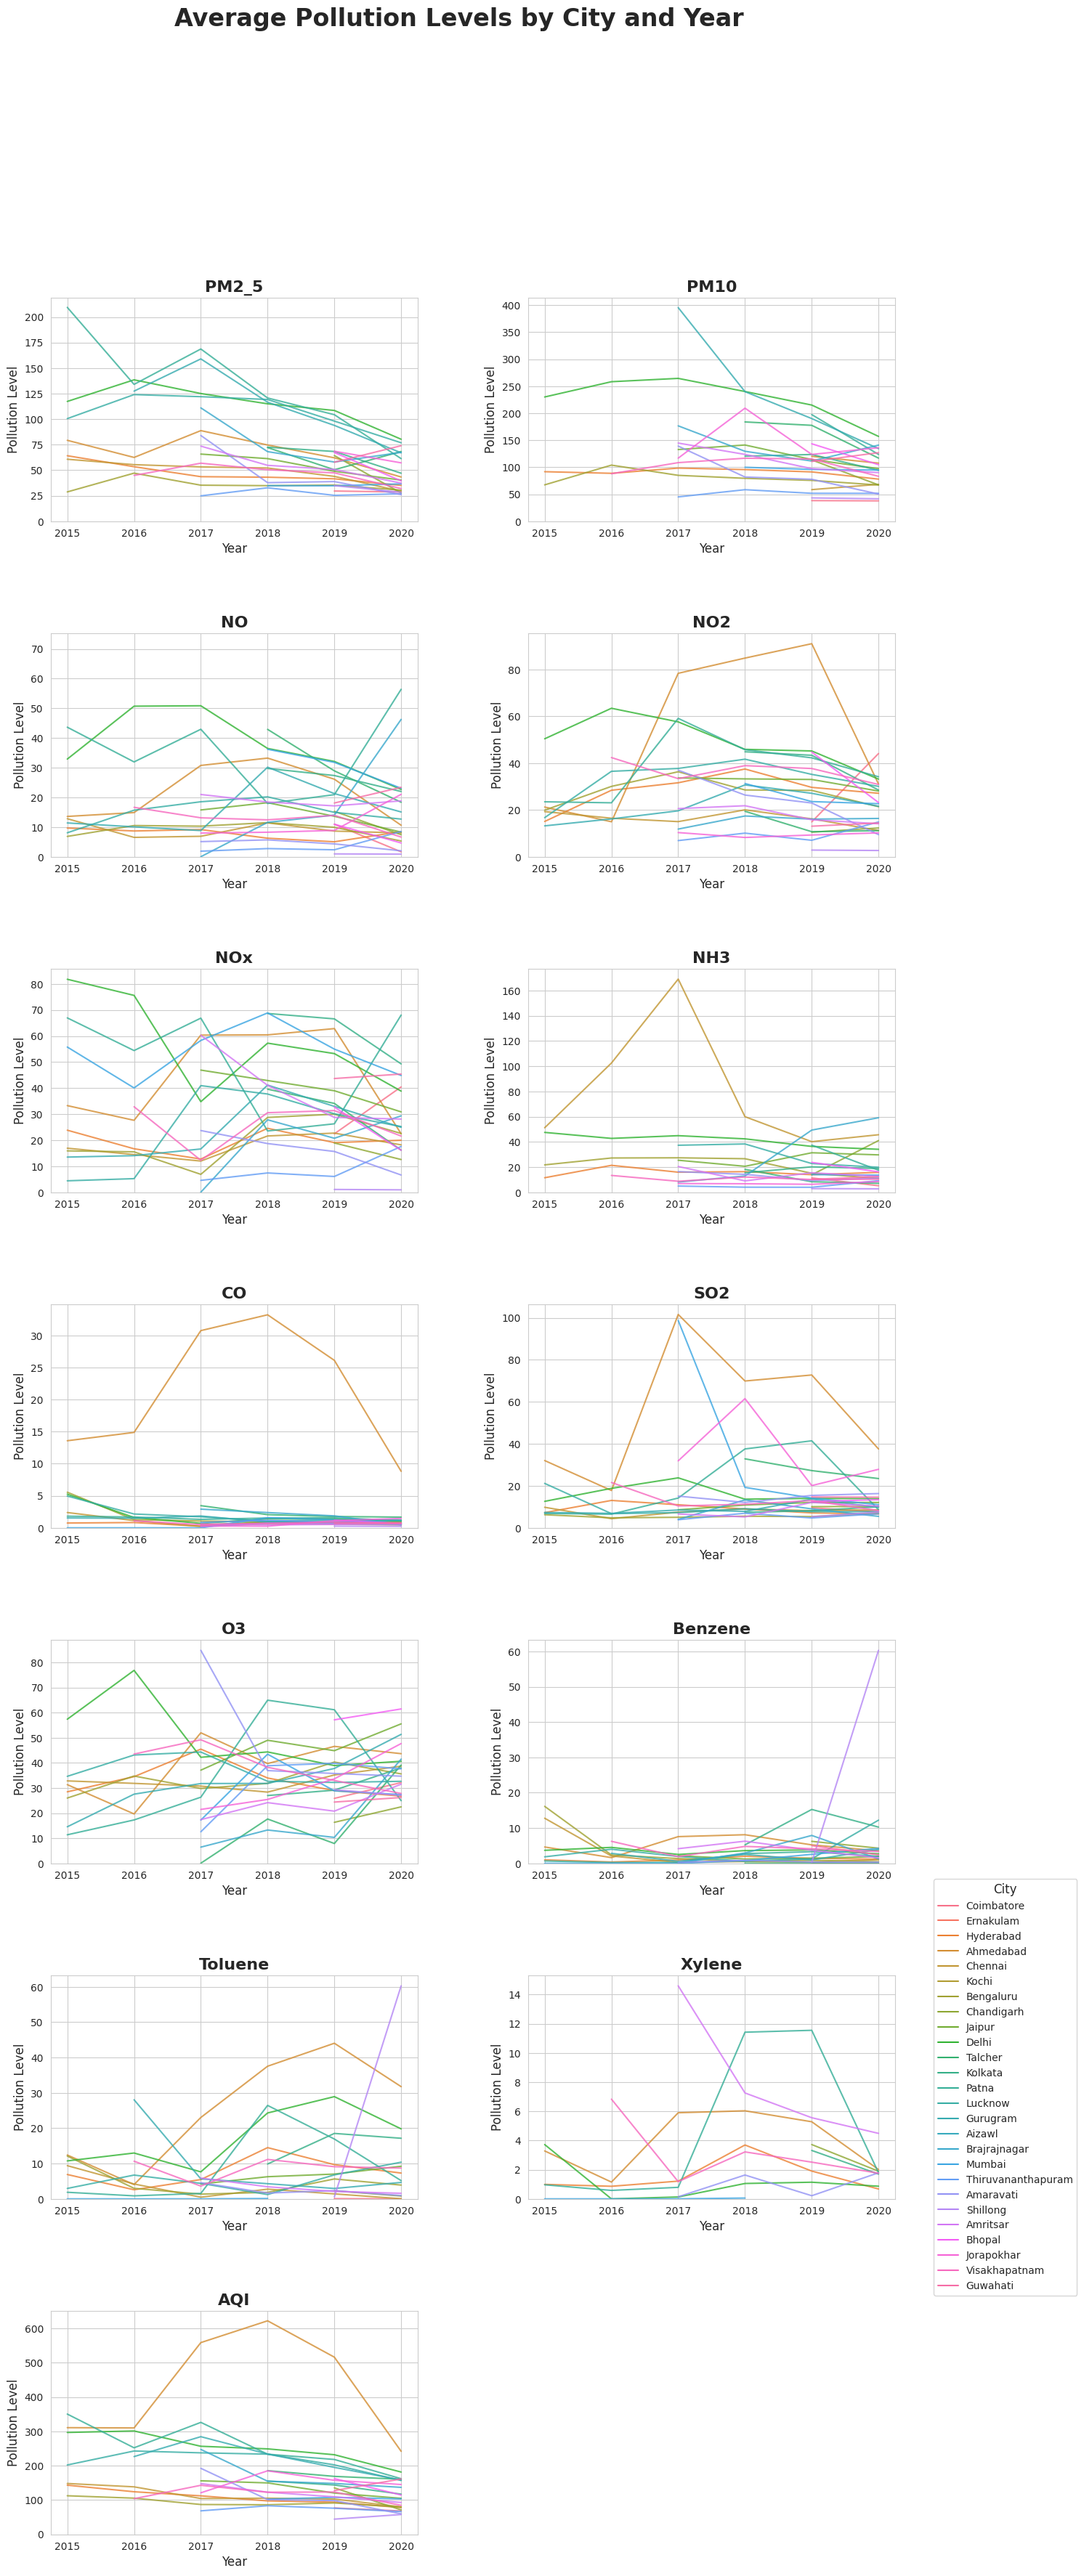

In [218]:
# Define the list of pollution factors
pollution_factors = ['PM2_5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI']

# Create a line chart for each pollution factor
sns.set_style('whitegrid')
fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(15,40))
lineplot_data = avg_pollution.toPandas()


for i, factor in enumerate(pollution_factors):
    row = i // 2
    column = i % 2
    ax = axs[row, column]
    if factor == 'City':
        continue
    sns.lineplot(x='year', y=factor, hue='City', data=lineplot_data, ax=ax, linewidth=1.5, alpha=0.8)
    ax.set_title(f'{factor}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Pollution Level', fontsize=12)
    ax.set_ylim(bottom=0)
    ax.tick_params(axis='both', which='major', labelsize=10)
    if i == len(pollution_factors) - 2:
        ax.legend(fontsize=10, title='City', title_fontsize=12, loc='center', bbox_to_anchor=(1.3, 0.5))
    else:
        ax.legend().remove()
    for line in ax.lines:
        line.set_linestyle('-')

# Remove the last row and column of plots
fig.delaxes(axs[-1, -1])

# Add a title for the entire plot
fig.suptitle('Average Pollution Levels by City and Year', fontsize=24, fontweight='bold')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.5)

plt.show()

To predict AQI (Air Quality Index), it would be best to keep all the columns that are related to the major air pollutants that affect AQI. These include:

PM2.5 (Particulate Matter 2.5 micrometers or less in diameter)
PM10 (Particulate Matter 10 micrometers or less in diameter)
NO2 (Nitrogen Dioxide)
SO2 (Sulfur Dioxide)
O3 (Ozone)
CO (Carbon Monoxide)
Columns such as NH3 (Ammonia), Benzene, Toluene, and Xylene may also contribute to air pollution, but they are not considered major air pollutants that directly affect AQI. Therefore, they could be dropped if they are not needed for the specific analysis or prediction of AQI.

In [219]:
df2 = df.alias("df2")
df2 = df2.drop('year')

# Filled by median

In [220]:
df2 = df2.fillna({
    'PM2_5': df2.select(F.median('PM2_5')).collect()[0][0],
    'PM10': df2.select(F.median('PM10')).collect()[0][0],
    'NO': df2.select(F.median('NO')).collect()[0][0],
    'NO2': df2.select(F.median('NO2')).collect()[0][0],
    'NOx': df2.select(F.median('NOx')).collect()[0][0],
    'NH3': df2.select(F.median('NH3')).collect()[0][0],
    'CO': df2.select(F.median('CO')).collect()[0][0],
    'SO2': df2.select(F.median('SO2')).collect()[0][0],
    'O3': df2.select(F.median('O3')).collect()[0][0],
    'Benzene': df2.select(F.median('Benzene')).collect()[0][0],
    'Toluene': df2.select(F.median('Toluene')).collect()[0][0],
    'Xylene': df2.select(F.median('Xylene')).collect()[0][0],
    'AQI': df2.select(F.median('AQI')).collect()[0][0],
})

In [221]:
df2 = df2.withColumn(
    'AQI_Bucket',
    F.when(F.isnull(F.col('AQI_Bucket')), 'Moderate').otherwise(F.col('AQI_Bucket'))
)

In [222]:
# the missing values are not an issue anymore

df2.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df2.columns]).show()

+----+----+-----+----+---+---+---+---+---+---+---+-------+-------+------+---+----------+
|City|Date|PM2_5|PM10| NO|NO2|NOx|NH3| CO|SO2| O3|Benzene|Toluene|Xylene|AQI|AQI_Bucket|
+----+----+-----+----+---+---+---+---+---+---+---+-------+-------+------+---+----------+
|   0|   0|    0|   0|  0|  0|  0|  0|  0|  0|  0|      0|      0|     0|  0|         0|
+----+----+-----+----+---+---+---+---+---+---+---+-------+-------+------+---+----------+



In [223]:
df2.show(5)

+---------+----------+-----+-----+----+-----+-----+-----+----+-----+------+-------+-------+------+-----+----------+
|     City|      Date|PM2_5| PM10|  NO|  NO2|  NOx|  NH3|  CO|  SO2|    O3|Benzene|Toluene|Xylene|  AQI|AQI_Bucket|
+---------+----------+-----+-----+----+-----+-----+-----+----+-----+------+-------+-------+------+-----+----------+
|Ahmedabad|2015-01-01|48.57|95.68|0.92|18.22|17.15|15.85|0.92|27.64|133.36|    0.0|   0.02|   0.0|118.0|  Moderate|
|Ahmedabad|2015-01-02|48.57|95.68|0.97|15.69|16.46|15.85|0.97|24.55| 34.06|   3.68|    5.5|  3.77|118.0|  Moderate|
|Ahmedabad|2015-01-03|48.57|95.68|17.4| 19.3| 29.7|15.85|17.4|29.07|  30.7|    6.8|   16.4|  2.25|118.0|  Moderate|
|Ahmedabad|2015-01-04|48.57|95.68| 1.7|18.48|17.97|15.85| 1.7|18.59| 36.08|   4.43|  10.14|   1.0|118.0|  Moderate|
|Ahmedabad|2015-01-05|48.57|95.68|22.1|21.42|37.76|15.85|22.1|39.33| 39.31|   7.01|  18.89|  2.78|118.0|  Moderate|
+---------+----------+-----+-----+----+-----+-----+-----+----+-----+----

In [224]:
AQI_df = df2.withColumn("Date", F.date_format("Date", 'yyyy-MM'))

AQI_df = AQI_df.groupBy(["City", "Date"]).agg(
F.mean("PM2_5").alias("PM2_5"), 
F.mean("PM10").alias("PM10"),
F.mean("NO").alias("NO"),
F.mean("NO2").alias("NO2"),
F.mean("NOx").alias("NOx"),
F.mean("NH3").alias("NH3"),
F.mean("CO").alias("CO"),
F.mean("SO2").alias("SO2"),
F.mean("O3").alias("O3"),
F.mean("Benzene").alias("Benzene"),
F.mean("Toluene").alias("Toluene"), 
F.mean("Xylene").alias("Xylene"), 
F.mean("AQI").alias("AQI"))


AQI_df = AQI_df.withColumnRenamed("date_format(Date, yyyy-MM)","Date")

# round the values to 2 decimals
for column in pollutants:
    AQI_df = AQI_df.withColumn(column, F.round(AQI_df[column], 2))
    
    
AQI_df = AQI_df.orderBy(['City', 'Date'])
AQI_df.show(10)

+---------+-------+------+-----+-----+-----+-----+-----+-----+-----+-----+-------+-------+------+------+
|     City|   Date| PM2_5| PM10|   NO|  NO2|  NOx|  NH3|   CO|  SO2|   O3|Benzene|Toluene|Xylene|   AQI|
+---------+-------+------+-----+-----+-----+-----+-----+-----+-----+-----+-------+-------+------+------+
|Ahmedabad|2015-01| 52.97|95.68|22.67|26.85|39.48|15.85|22.38| 43.6|46.35|   1.46|   2.53|  2.98|140.48|
|Ahmedabad|2015-02|108.87|95.68|20.54|30.28|48.06|15.85|19.58| 57.4|46.74|   7.82|  21.06|  7.02| 477.5|
|Ahmedabad|2015-03|108.47|95.68| 13.9|27.74|40.65|15.85|13.61|57.27|45.27|  10.65|   26.9|  3.97|389.48|
|Ahmedabad|2015-04|101.68|95.68| 7.31|20.75|26.93|15.85| 7.31|51.23|31.38|   2.68|   7.46|  4.35|276.87|
|Ahmedabad|2015-05| 74.92|95.68| 8.53|17.33|24.75|15.85| 8.53|35.98|31.62|   3.69|  10.78|  5.21|258.77|
|Ahmedabad|2015-06| 48.97|95.68|  7.9|13.89|21.68|15.85|  7.9|12.33|12.08|   1.91|   5.55|  0.64|207.07|
|Ahmedabad|2015-07| 52.42|95.68| 5.85|  7.5|13.11|15.85

+-------+------------------+
|   Date|               AQI|
+-------+------------------+
|2015-01|153.25285714285715|
|2015-02|199.34714285714287|
|2015-03|190.22857142857146|
|2015-04| 177.7342857142857|
|2015-05|182.09142857142857|
+-------+------------------+
only showing top 5 rows



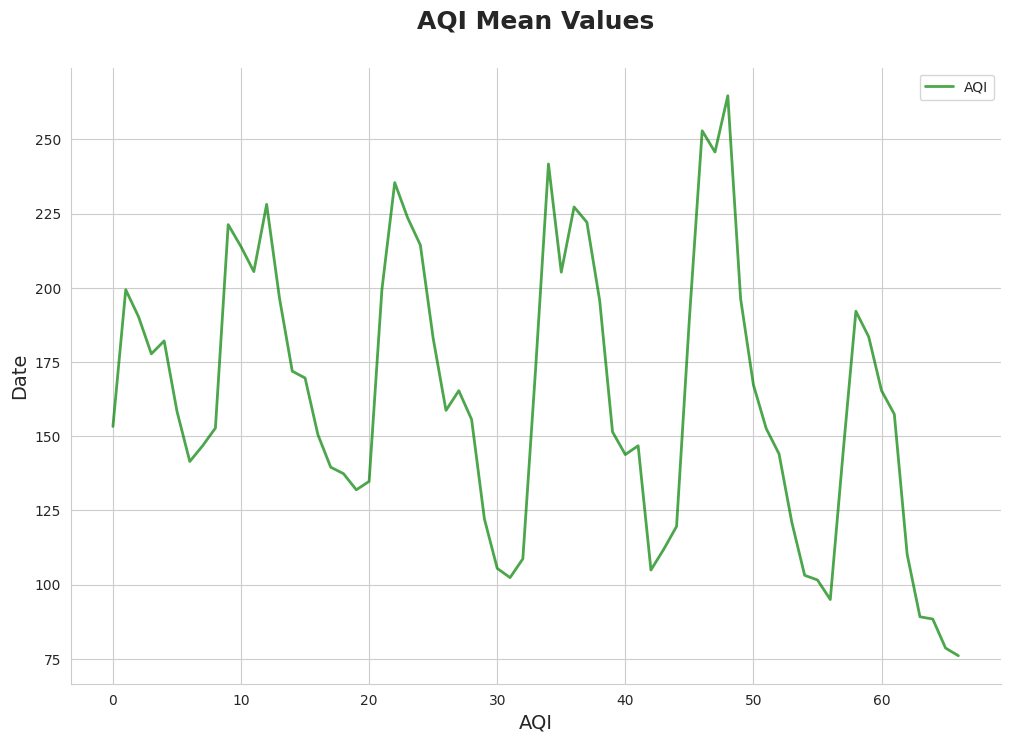

In [225]:
# Group the data by date and compute the median AQI for each date
median_aqi_by_date1 = AQI_df.groupBy(["Date"]).agg(
F.mean("AQI").alias("AQI")
)
median_aqi_by_date1 = median_aqi_by_date1.orderBy(['Date'])

median_aqi_by_date1.show(5)

# Create a line plot of the mean AQI values
fig, ax = plt.subplots(figsize=(12, 8))
median_aqi_by_date1.toPandas().plot(kind='line', ax=ax, color='green', linewidth=2, alpha=0.7)

# Customize the plot
ax.set_title('AQI Mean Values', fontsize=18, fontweight='bold', y=1.05)
ax.set_xlabel('AQI', fontsize=14)
ax.set_ylabel('Date', fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
sns.despine()

# Add shaded regions to highlight specific areas of interest
# ax.axvspan('2015-01', '2015-04', color='green', alpha=0.2)
# ax.text('2019-12-01', 200, 'COVID-19 Period', fontsize=12, color='black', ha='left', va='center')


# Show the plot
plt.show()


+-------+------------------+
|   Date|               AQI|
+-------+------------------+
|2015-01|153.25285714285715|
|2015-02|199.34714285714287|
|2015-03|190.22857142857146|
|2015-04| 177.7342857142857|
|2015-05|182.09142857142857|
+-------+------------------+
only showing top 5 rows



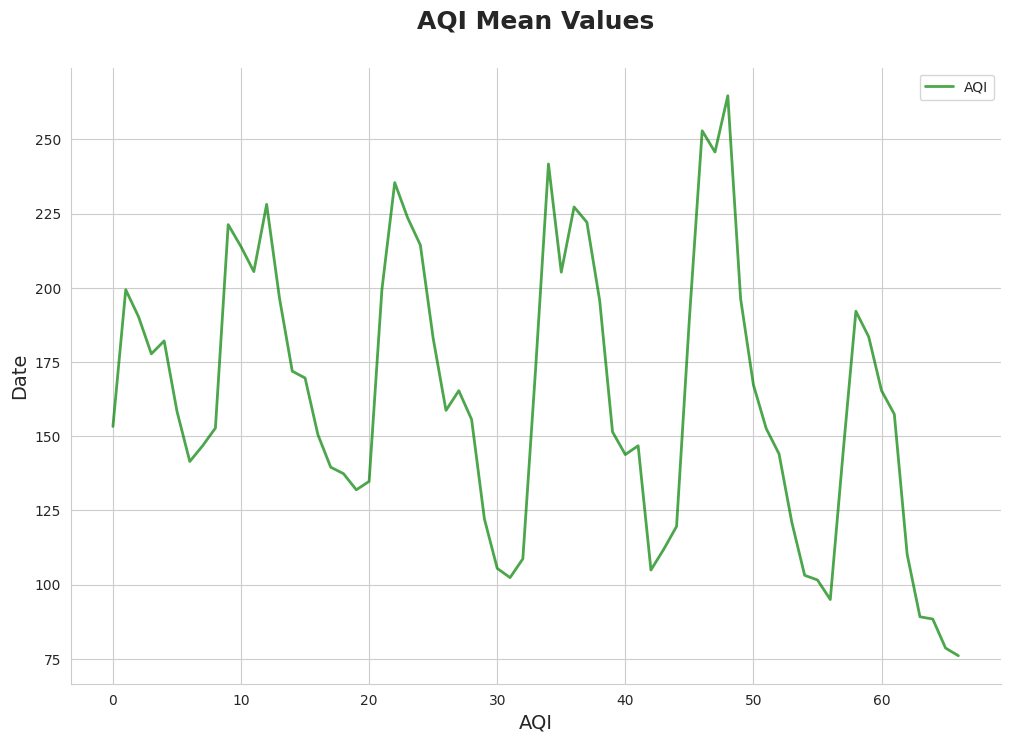

In [226]:
# Group the data by date and compute the median AQI for each date
median_aqi_by_date1 = AQI_df.groupBy(["Date"]).agg(
F.mean("AQI").alias("AQI")
)
median_aqi_by_date1 = median_aqi_by_date1.orderBy(['Date'])

median_aqi_by_date1.show(5)

# Create a line plot of the mean AQI values
fig, ax = plt.subplots(figsize=(12, 8))
median_aqi_by_date1.toPandas().plot(kind='line', ax=ax, color='green', linewidth=2, alpha=0.7)

# Customize the plot
ax.set_title('AQI Mean Values', fontsize=18, fontweight='bold', y=1.05)
ax.set_xlabel('AQI', fontsize=14)
ax.set_ylabel('Date', fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
sns.despine()

# Add shaded regions to highlight specific areas of interest
# ax.axvspan('2015-01', '2015-04', color='green', alpha=0.2)
# ax.text('2019-12-01', 200, 'COVID-19 Period', fontsize=12, color='black', ha='left', va='center')


# Show the plot
plt.show()

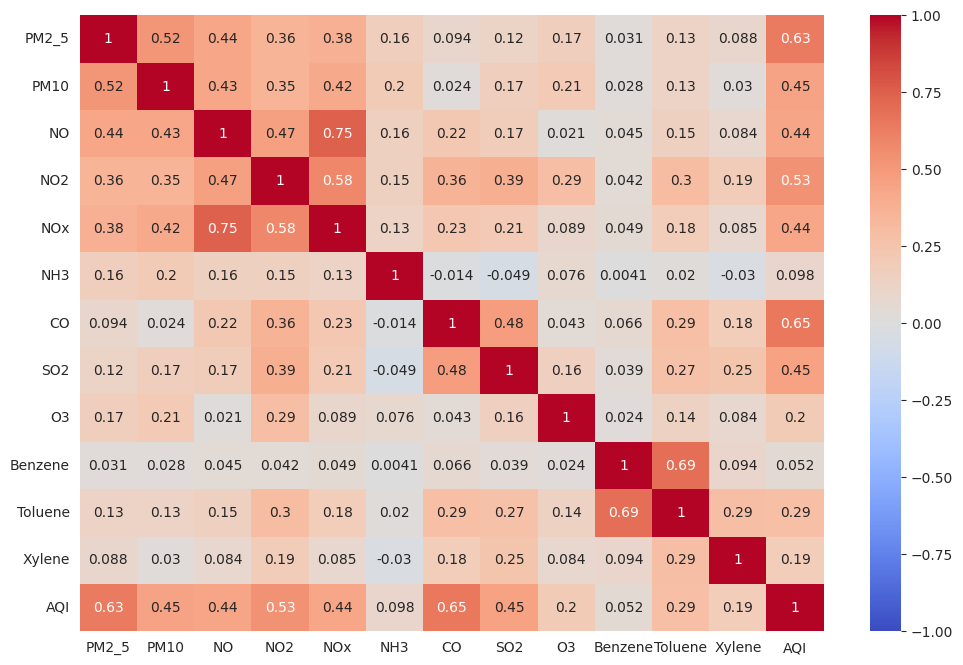

In [227]:
plt.figure(figsize=(12, 8))

# Calculate the correlation matrix
corr = df2.drop('City', 'Date', 'AQI_Bucket').toPandas().corr()

# Plot the correlation matrix
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

# Comparing with values replaced by Median

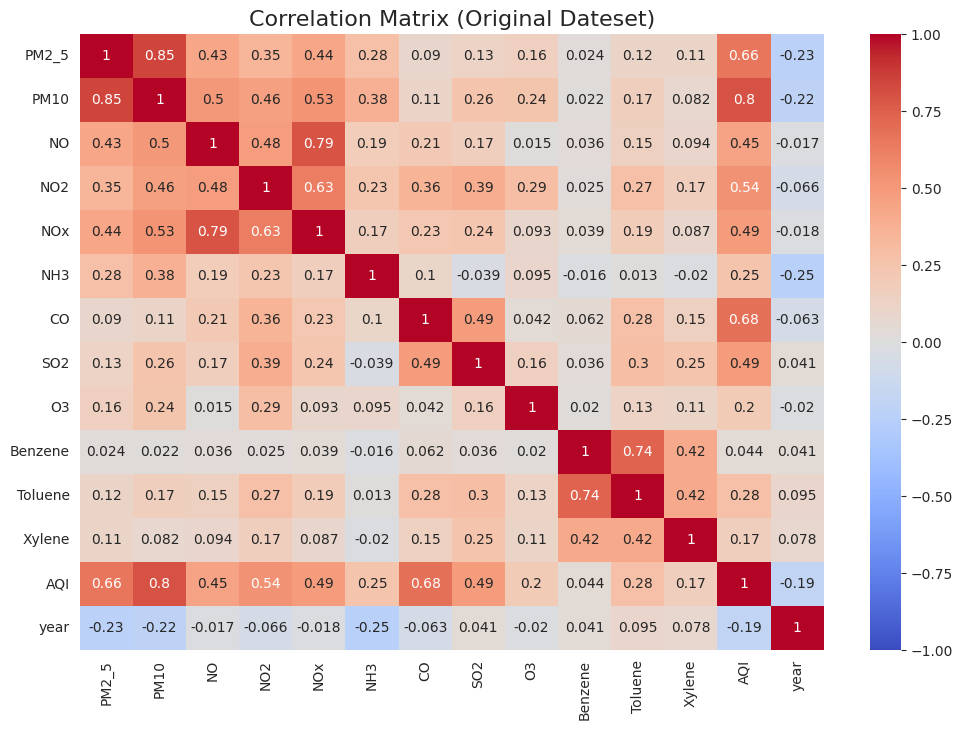

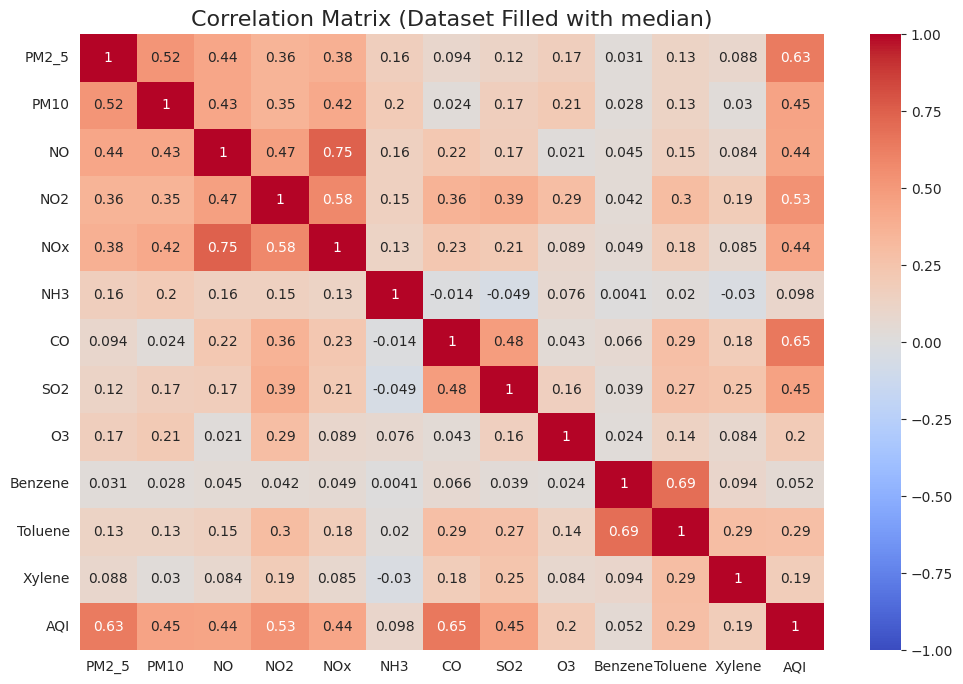

In [228]:
plt.figure(figsize=(12, 8))

# Plot correlation matrix for original data
corr = df.drop('City', 'Date', 'AQI_Bucket').toPandas().corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix (Original Dateset)", fontsize=16)
plt.show()

# Plot correlation matrix for replaced values
plt.figure(figsize=(12, 8))
corr = df2.drop('City', 'Date', 'AQI_Bucket').toPandas().corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix (Dataset Filled with median)", fontsize=16)
plt.show()

Looking at the corelation matrix, we can clearly see that these gases( NH3 (Ammonia), Benzene, Toluene, and Xylene) are not highly corelated to AQI and may also contribute to air pollution, but they are not considered major air pollutants that directly affect AQI. Therefore, they could be dropped if they are not needed for the specific analysis or prediction of AQI.

Looking at the missing values graph, Xylene had more missing values of more than 60%. So this is resonable to drop these columns

In [229]:
df2 = df2.drop("NH3","Benzene", "Toulene", "Xylene")
df2.show(5)

+---------+----------+-----+-----+----+-----+-----+----+-----+------+-------+-----+----------+
|     City|      Date|PM2_5| PM10|  NO|  NO2|  NOx|  CO|  SO2|    O3|Toluene|  AQI|AQI_Bucket|
+---------+----------+-----+-----+----+-----+-----+----+-----+------+-------+-----+----------+
|Ahmedabad|2015-01-01|48.57|95.68|0.92|18.22|17.15|0.92|27.64|133.36|   0.02|118.0|  Moderate|
|Ahmedabad|2015-01-02|48.57|95.68|0.97|15.69|16.46|0.97|24.55| 34.06|    5.5|118.0|  Moderate|
|Ahmedabad|2015-01-03|48.57|95.68|17.4| 19.3| 29.7|17.4|29.07|  30.7|   16.4|118.0|  Moderate|
|Ahmedabad|2015-01-04|48.57|95.68| 1.7|18.48|17.97| 1.7|18.59| 36.08|  10.14|118.0|  Moderate|
|Ahmedabad|2015-01-05|48.57|95.68|22.1|21.42|37.76|22.1|39.33| 39.31|  18.89|118.0|  Moderate|
+---------+----------+-----+-----+----+-----+-----+----+-----+------+-------+-----+----------+
only showing top 5 rows



In [230]:
df2 = df2.withColumn('year', F.year('Date'))

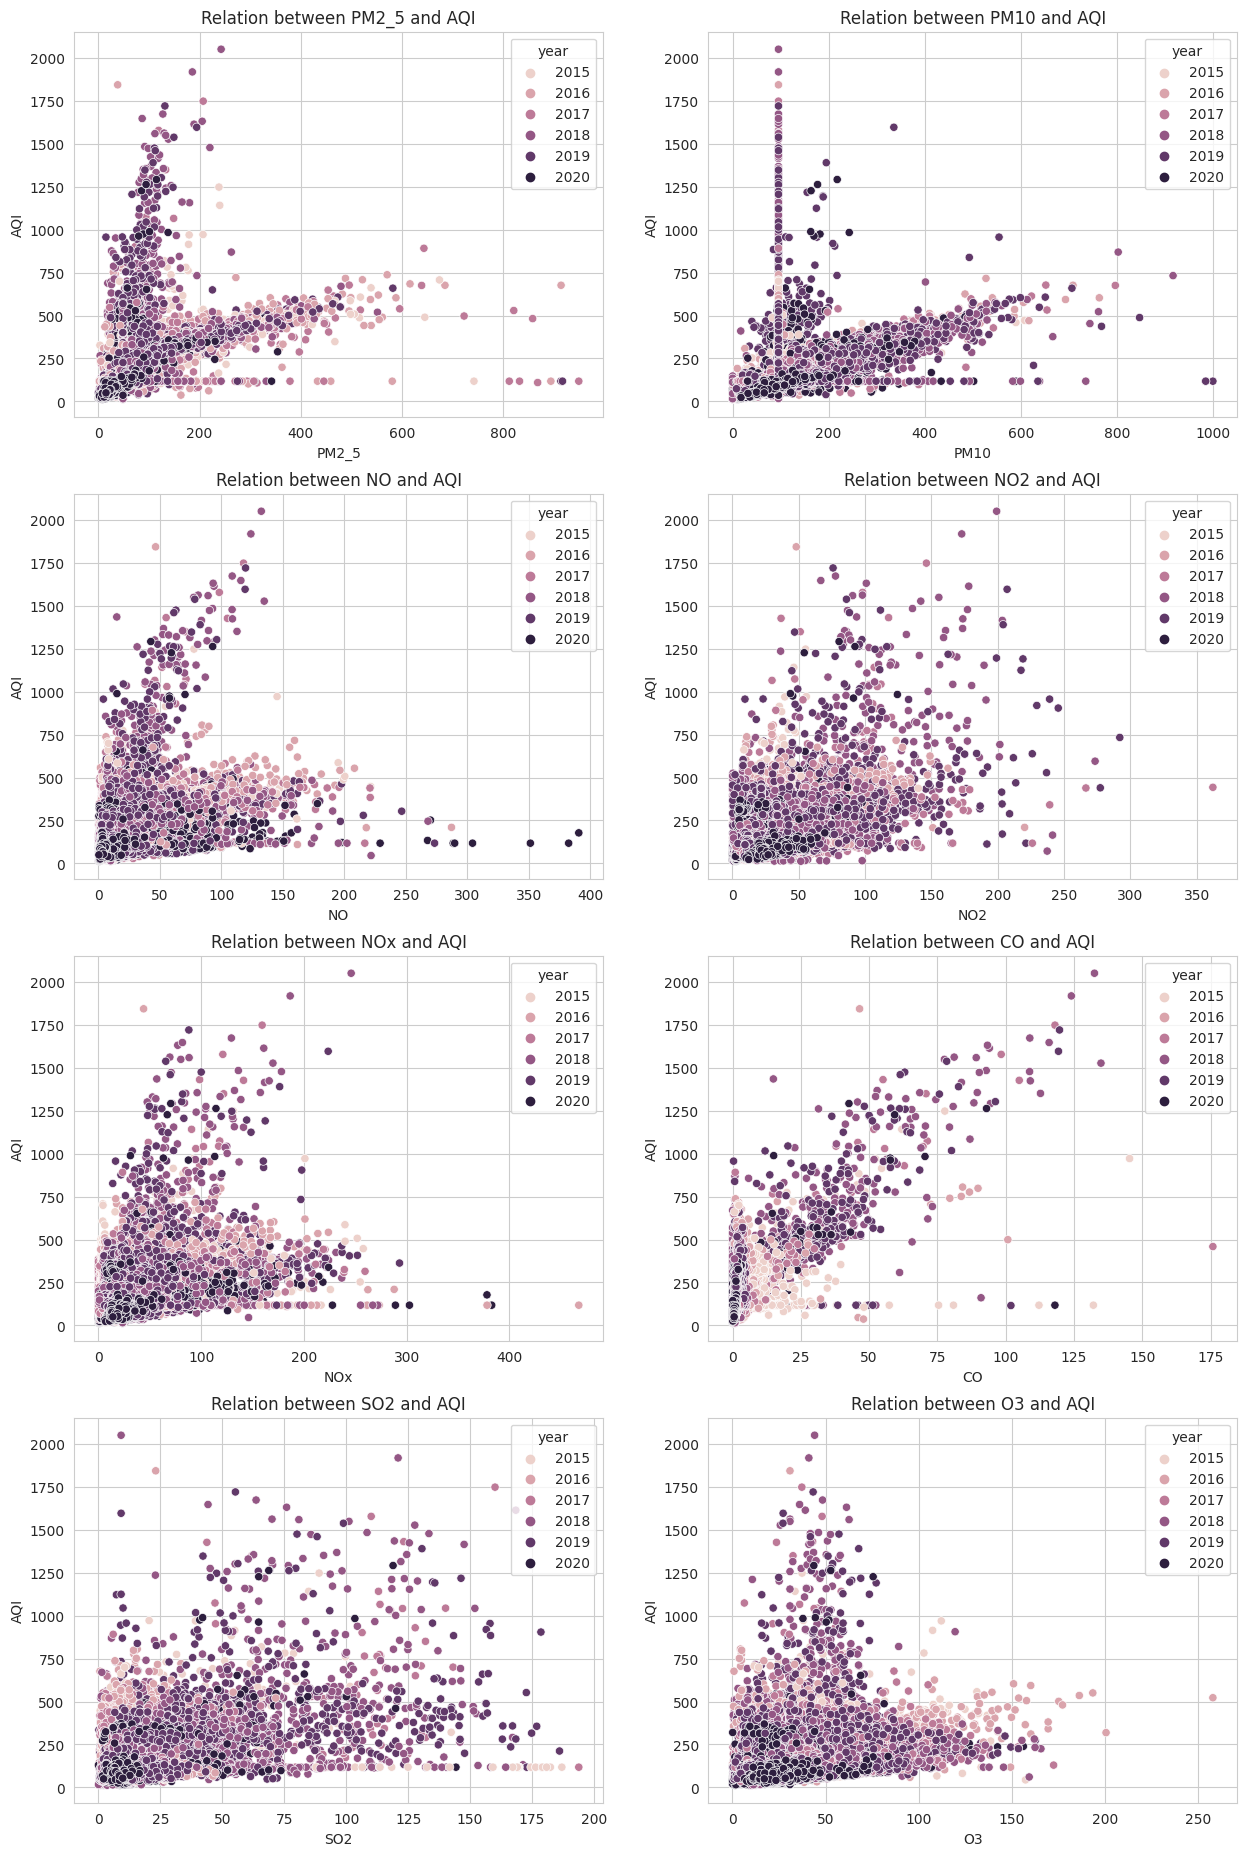

In [231]:
variables = ['PM2_5', 'PM10', 'NO', 'NO2', 'NOx','CO', 'SO2', 'O3']

fig= plt.figure(figsize=(15,35))
for variable, num in zip(variables, range(1, len(variables) + 1)):
    ax = fig.add_subplot(6,2,num)
    sns.scatterplot(x=variable, y='AQI',hue='year', data=df2.toPandas())
    plt.title('Relation between {} and AQI'.format(variable))
    plt.xlabel(variable)
    plt.ylabel('AQI')

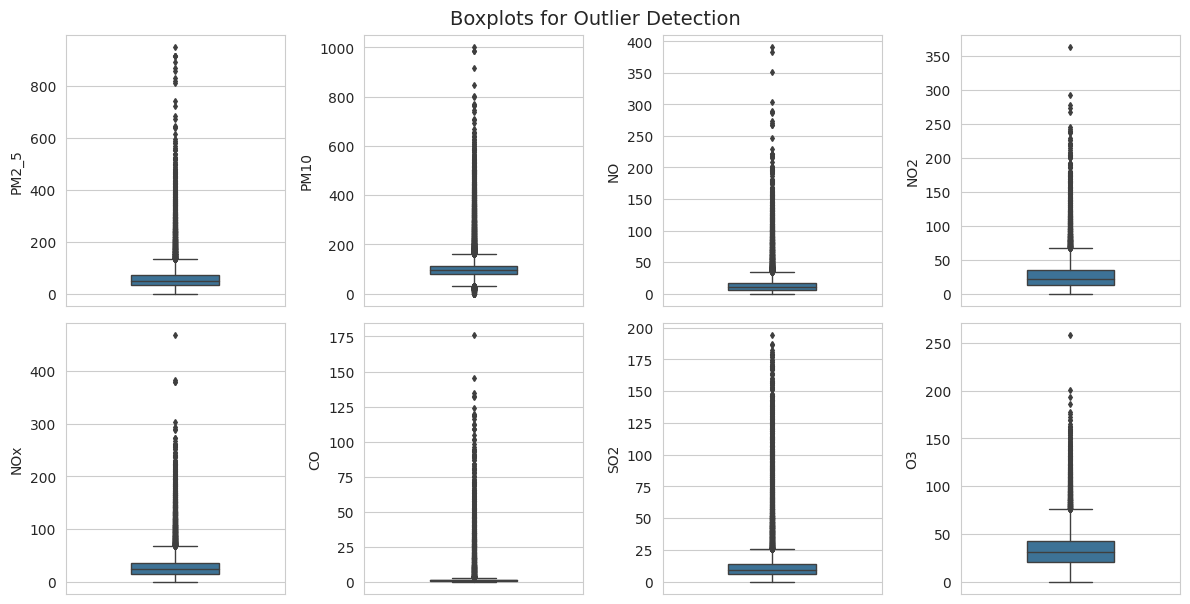

In [232]:
# Select the columns to check for outliers
cols = ['PM2_5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'SO2', 'O3']

# Create a figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
axes = axes.flatten()

# Loop through each column and create a boxplot
for i, column in enumerate(cols):
    boxplot_data = df2.select(column).toPandas()
    sns.boxplot(y=boxplot_data[column], ax=axes[i], width=0.4, fliersize=3, linewidth=1, notch=False, saturation=0.6)
    axes[i].set_xlabel('')
    axes[i].set_ylabel(column, fontsize=10)

# Remove empty subplots
for i in range(len(cols), len(axes)):
    axes[i].remove()

# Add a title to the figure
fig.suptitle('Boxplots for Outlier Detection', fontsize=14)

# Adjust spacing between subplots and save the figure
fig.tight_layout()
plt.savefig('outlier_boxplots.png')
plt.show()


In [233]:
#create a list of columns to transform
cols_to_transform = ['PM2_5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'SO2', 'AQI', 'O3']

# apply the logarithm to each value in the specified columns
for column in cols_to_transform:
    df2 = df2.withColumn(column, F.round(F.log(df2[column]), 2))
    
df2.show()

+---------+----------+-----+----+-----+----+----+-----+----+----+-------+----+----------+----+
|     City|      Date|PM2_5|PM10|   NO| NO2| NOx|   CO| SO2|  O3|Toluene| AQI|AQI_Bucket|year|
+---------+----------+-----+----+-----+----+----+-----+----+----+-------+----+----------+----+
|Ahmedabad|2015-01-01| 3.88|4.56|-0.08| 2.9|2.84|-0.08|3.32|4.89|   0.02|4.77|  Moderate|2015|
|Ahmedabad|2015-01-02| 3.88|4.56|-0.03|2.75| 2.8|-0.03| 3.2|3.53|    5.5|4.77|  Moderate|2015|
|Ahmedabad|2015-01-03| 3.88|4.56| 2.86|2.96|3.39| 2.86|3.37|3.42|   16.4|4.77|  Moderate|2015|
|Ahmedabad|2015-01-04| 3.88|4.56| 0.53|2.92|2.89| 0.53|2.92|3.59|  10.14|4.77|  Moderate|2015|
|Ahmedabad|2015-01-05| 3.88|4.56|  3.1|3.06|3.63|  3.1|3.67|3.67|  18.89|4.77|  Moderate|2015|
|Ahmedabad|2015-01-06| 3.88|4.56| 3.82|3.65| 4.4| 3.82|3.82|3.84|  10.83|4.77|  Moderate|2015|
|Ahmedabad|2015-01-07| 3.88|4.56| 4.72| 3.7|4.87| 4.72|3.47|3.51|    0.0|4.77|  Moderate|2015|
|Ahmedabad|2015-01-08| 3.88|4.56| 4.39| 3.6|4.57| 

This operation is often used when the original data has a skewed distribution, and transforming it with a logarithm can help normalize the distribution, allowing for more accurate analysis and modeling.

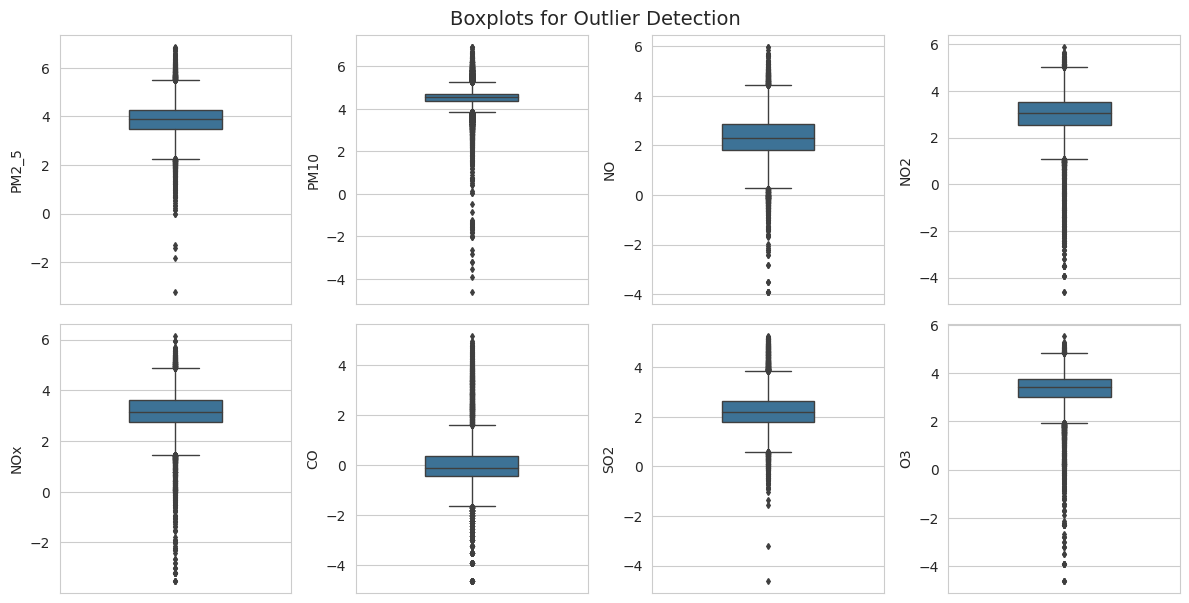

In [234]:
# Select the columns to check for outliers
cols = ['PM2_5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'SO2', 'O3']

# Create a figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
axes = axes.flatten()

# Loop through each column and create a boxplot
for i, column in enumerate(cols):
    boxplot_data = df2.select(column).toPandas()
    sns.boxplot(y=boxplot_data[column], ax=axes[i], width=0.4, fliersize=3, linewidth=1, notch=False, saturation=0.6)
    axes[i].set_xlabel('')
    axes[i].set_ylabel(column, fontsize=10)

# Remove empty subplots
for i in range(len(cols), len(axes)):
    axes[i].remove()

# Add a title to the figure
fig.suptitle('Boxplots for Outlier Detection', fontsize=14)

# Adjust spacing between subplots and save the figure
fig.tight_layout()
plt.savefig('outlier_boxplots.png')
plt.show()

**Calculate interquartile range (IQR) and remove outliers**

In [235]:
df3 = df2.alias('df3')
df3 = df3.drop("Date")

ignore_columns = ['City', 'AQI_Bucket']

# ignore certain columns when calculating outliers
columns = []
for value in df3.columns:
    if(value in ignore_columns):
        continue
    columns.append(value)

quantiles = df3.approxQuantile(columns, [0.25, 0.75], 0.01)

Q1 = {}
Q3 = {}

for i, column in enumerate(columns):
    Q1[column] = quantiles[i][0]
    Q3[column] = quantiles[i][1]
      
IQR = {}


for column in columns:
    IQR[column] = Q3[column] - Q1[column]
    
test = 'test'
    
for column in columns:
    upper_bound = Q3[column] + 1.5 * IQR[column]
    lower_bound = Q1[column] - 1.5 * IQR[column]
    df3 = df3.filter((F.col(column) > (Q1[column] - 1.5 * IQR[column])) & (F.col(column) < (Q3[column] + 1.5 * IQR[column])))

In [236]:
df3.show(5)

+---------+-----+----+----+----+----+----+----+----+-------+----+----------+----+
|     City|PM2_5|PM10|  NO| NO2| NOx|  CO| SO2|  O3|Toluene| AQI|AQI_Bucket|year|
+---------+-----+----+----+----+----+----+----+----+-------+----+----------+----+
|Ahmedabad| 3.88|4.56|0.53|2.92|2.89|0.53|2.92|3.59|  10.14|4.77|  Moderate|2015|
|Ahmedabad| 3.88|4.56|0.49|3.08|3.13|0.49|3.64|3.83|   0.05|4.77|  Moderate|2015|
|Ahmedabad| 3.88|4.56|0.71|3.02|3.06|0.71|3.69|3.48|    0.7|4.77|  Moderate|2015|
|Ahmedabad| 3.88|4.56|0.82|3.05|3.08|0.82|3.78|3.68|    0.0|4.77|  Moderate|2015|
|Ahmedabad| 3.88|4.56|0.78|3.08|3.15|0.78|3.77|3.72|    0.0|4.77|  Moderate|2015|
+---------+-----+----+----+----+----+----+----+----+-------+----+----------+----+
only showing top 5 rows



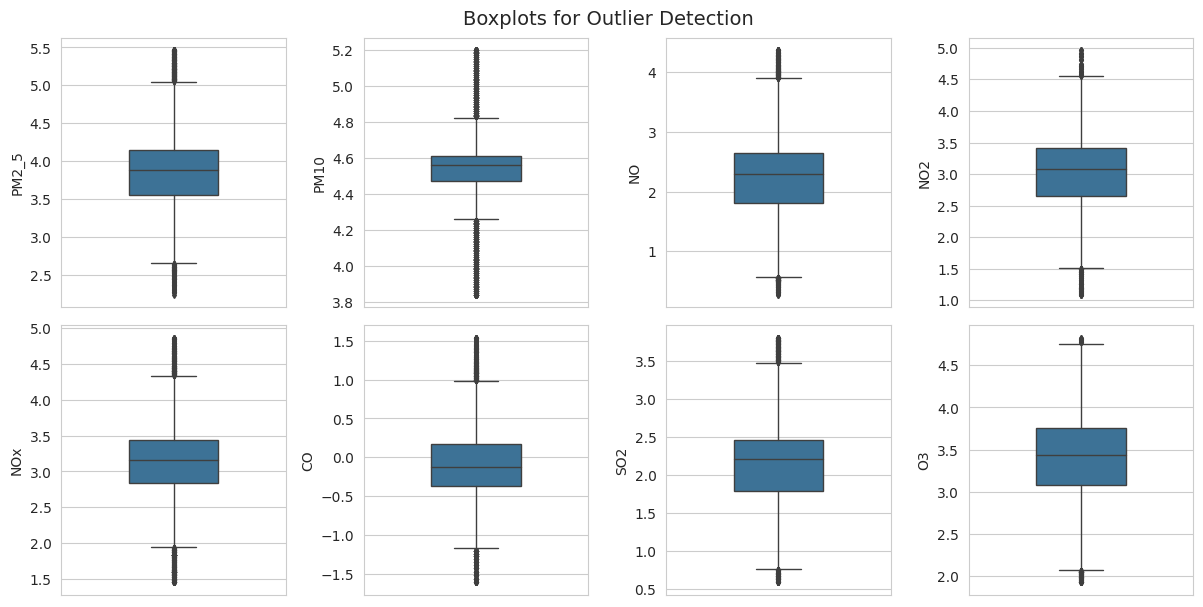

In [238]:
# Select the columns to check for outliers
cols = ['PM2_5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'SO2', 'O3']

# Create a figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
axes = axes.flatten()

# Loop through each column and create a boxplot
for i, column in enumerate(cols):
    boxplot_data = df3.select(column).toPandas()
    sns.boxplot(y=boxplot_data[column], ax=axes[i], width=0.4, fliersize=3, linewidth=1, notch=False, saturation=0.6)
    axes[i].set_xlabel('')
    axes[i].set_ylabel(column, fontsize=10)

# Remove empty subplots
for i in range(len(cols), len(axes)):
    axes[i].remove()

# Add a title to the figure
fig.suptitle('Boxplots for Outlier Detection', fontsize=14)

# Adjust spacing between subplots and save the figure
fig.tight_layout()
plt.savefig('outlier_boxplots.png')
plt.show()

In [239]:
from sklearn.preprocessing import LabelEncoder

city_data = df3.toPandas()['City']
aqi_bucket = df3.toPandas()['AQI_Bucket']

le=LabelEncoder()

city_indexer = StringIndexer(inputCol='City', outputCol='City_Index')
city_indexer_model = city_indexer.fit(df3)

aqi_bucket_indexer = StringIndexer(inputCol='AQI_Bucket', outputCol='AQI_BucketIndex')
aqi_bucket_indexer_model = aqi_bucket_indexer.fit(df3)

df3 = city_indexer_model.transform(df3)
df3 = aqi_bucket_indexer_model.transform(df3)

**Displaying indexes assigned to their corresponding labels**

In [240]:
df3.show(10)

+---------+-----+----+----+----+----+-----+----+----+-------+----+----------+----+----------+---------------+
|     City|PM2_5|PM10|  NO| NO2| NOx|   CO| SO2|  O3|Toluene| AQI|AQI_Bucket|year|City_Index|AQI_BucketIndex|
+---------+-----+----+----+----+----+-----+----+----+-------+----+----------+----+----------+---------------+
|Ahmedabad| 3.88|4.56|0.53|2.92|2.89| 0.53|2.92|3.59|  10.14|4.77|  Moderate|2015|      10.0|            0.0|
|Ahmedabad| 3.88|4.56|0.49|3.08|3.13| 0.49|3.64|3.83|   0.05|4.77|  Moderate|2015|      10.0|            0.0|
|Ahmedabad| 3.88|4.56|0.71|3.02|3.06| 0.71|3.69|3.48|    0.7|4.77|  Moderate|2015|      10.0|            0.0|
|Ahmedabad| 3.88|4.56|0.82|3.05|3.08| 0.82|3.78|3.68|    0.0|4.77|  Moderate|2015|      10.0|            0.0|
|Ahmedabad| 3.88|4.56|0.78|3.08|3.15| 0.78|3.77|3.72|    0.0|4.77|  Moderate|2015|      10.0|            0.0|
|Ahmedabad| 4.39|4.56|0.86|3.13|3.18| 0.86|3.25|3.86|    0.0|5.68|      Poor|2015|      10.0|            2.0|
|Ahmedabad

In [241]:
for i, label in enumerate(aqi_bucket_indexer_model.labels):
    print(f"{label} is assigned index {i}")

Moderate is assigned index 0
Satisfactory is assigned index 1
Poor is assigned index 2
Very Poor is assigned index 3
Good is assigned index 4
Severe is assigned index 5


In [242]:
for i, label in enumerate(city_indexer_model.labels):
    print(f"{label} is assigned index {i}")

Chennai is assigned index 0
Lucknow is assigned index 1
Bengaluru is assigned index 2
Hyderabad is assigned index 3
Gurugram is assigned index 4
Patna is assigned index 5
Visakhapatnam is assigned index 6
Jaipur is assigned index 7
Mumbai is assigned index 8
Amritsar is assigned index 9
Ahmedabad is assigned index 10
Jorapokhar is assigned index 11
Amaravati is assigned index 12
Brajrajnagar is assigned index 13
Thiruvananthapuram is assigned index 14
Delhi is assigned index 15
Talcher is assigned index 16
Kolkata is assigned index 17
Guwahati is assigned index 18
Bhopal is assigned index 19
Chandigarh is assigned index 20
Coimbatore is assigned index 21
Shillong is assigned index 22
Kochi is assigned index 23
Ernakulam is assigned index 24


# Splitting Dataset

In [243]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, r2_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [244]:
tm = df3.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df3.columns])
tm.show()

+----+-----+----+---+---+---+---+---+---+-------+---+----------+----+----------+---------------+
|City|PM2_5|PM10| NO|NO2|NOx| CO|SO2| O3|Toluene|AQI|AQI_Bucket|year|City_Index|AQI_BucketIndex|
+----+-----+----+---+---+---+---+---+---+-------+---+----------+----+----------+---------------+
|   0|    0|   0|  0|  0|  0|  0|  0|  0|      0|  0|         0|   0|         0|              0|
+----+-----+----+---+---+---+---+---+---+-------+---+----------+----+----------+---------------+



In [245]:
y = df3.toPandas()["AQI"]
X = df3.toPandas()[['PM2_5', 'PM10', 'NOx','NO','NO2', 'CO', 'SO2','O3']]

In [246]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest regressor object
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the regressor with the training data
rf.fit(X_train, y_train)

# Use the trained model to make predictions on the test set
y_pred = rf.predict(X_test)

# Calculate mean squared error on test data
mse = mean_squared_error(y_test, y_pred)
print('MSE: ', mse)

# Print the R-squared score of the model on the test set
print("R-squared score:", rf.score(X_test, y_test))

MSE:  0.035230816347986846
R-squared score: 0.8090214974043064


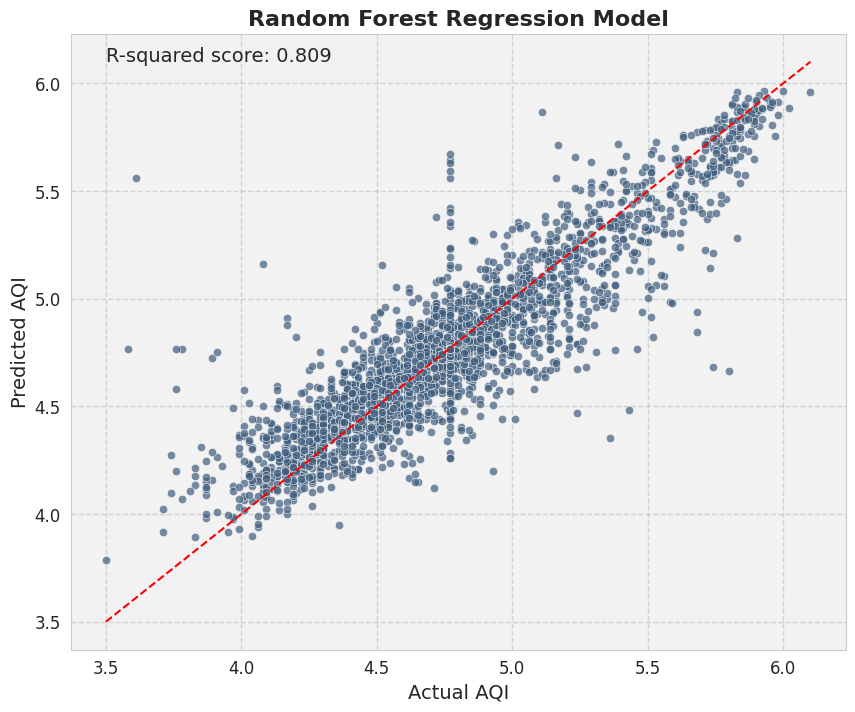

In [247]:
import matplotlib.pyplot as plt
import seaborn as sns

#Create a scatterplot with actual vs predicted values
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test, y=y_pred, color='#3F5D7D', alpha=0.7)
plt.xlabel('Actual AQI', fontsize=14)
plt.ylabel('Predicted AQI', fontsize=14)
plt.title('Random Forest Regression Model', fontsize=16, fontweight='bold')

#Add a diagonal line for comparison
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

#Add text for R-squared value
plt.text(y_test.min(), y_test.max(), f"R-squared score: {rf.score(X_test, y_test):.3f}", fontsize=14)

#Customize tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#Add grid lines
plt.grid(color='#95A5A6', linestyle='--', linewidth=1, alpha=0.4)

#Set background color
ax = plt.gca()
ax.set_facecolor('#F2F2F2')

#Save the plot as a PNG image
plt.savefig('random_forest_regression.png', dpi=300, bbox_inches='tight')

plt.show()

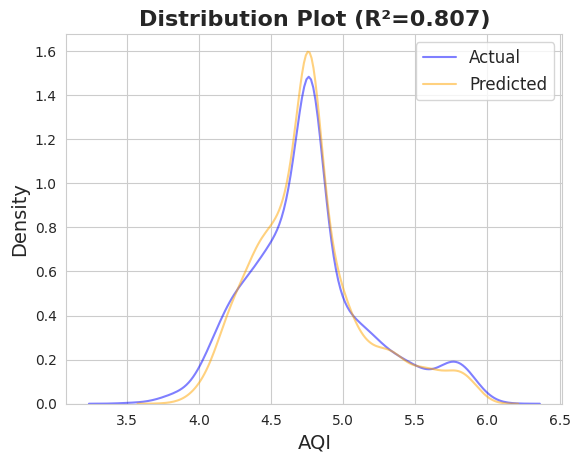

In [248]:
# Fit a random forest regression model to the data
rf = RandomForestRegressor(n_estimators=100)
rf_model = rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)

# Create a distribution plot
sns.kdeplot(y_test, label='Actual', color='blue', alpha=0.5, linewidth=1.5)
sns.kdeplot(y_pred, label='Predicted', color='orange', alpha=0.5, linewidth=1.5)
plt.xlabel('AQI', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title(f'Distribution Plot (R²={r2:.3f})', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.show()

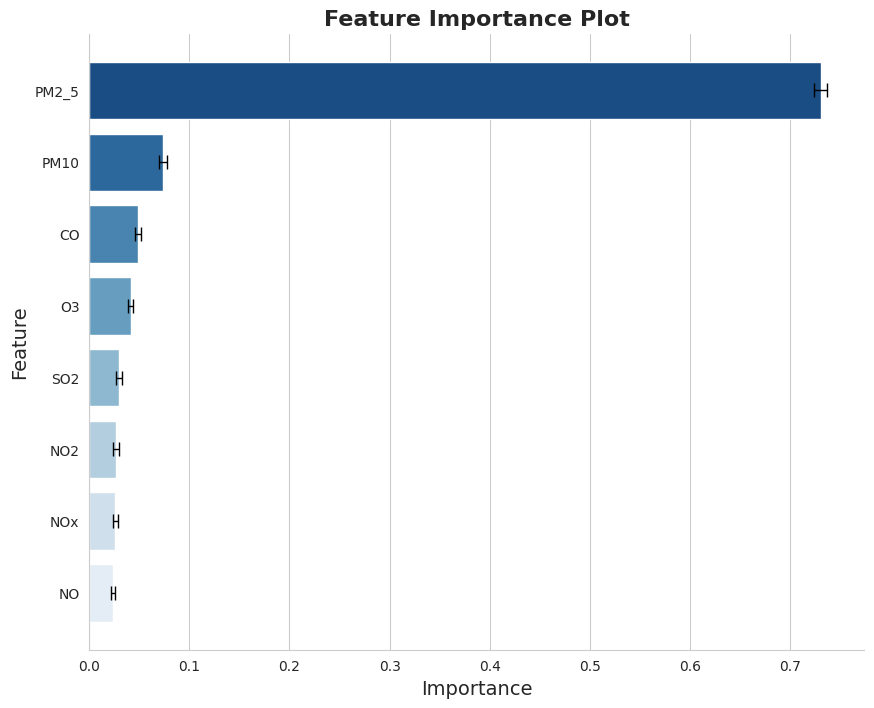

In [249]:
# Create a feature importance plot
importances = rf.feature_importances_

# Set color palette
palette = sns.color_palette("Blues_r", len(indices))

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=importances[indices], y=[X.columns[i] for i in indices], palette=palette)

# Customize plot
ax.set_xlabel('Importance', fontsize=14)
ax.set_ylabel('Feature', fontsize=14)
ax.set_title('Feature Importance Plot', fontsize=16, fontweight='bold')
sns.despine()

# Add error bars
for i, v in enumerate(indices):
    ax.errorbar(importances[v], i, xerr=std[v], linestyle='None', color='black', linewidth=1, capsize=5)

# Show plot
plt.show()

In [251]:
# Define AQI thresholds for each category
aqi_thresholds = {
    'Good': (0, 50),
    'Moderate': (51, 100),
    'Satisfactory': (101, 200),
    'Poor': (201, 300),
    'Very Poor': (301, 400),
    'Severe': (401, 500)
}

# Create a list to hold the predicted AQI buckets
y_pred_bucket = []

# Assign the corresponding AQI bucket to each predicted AQI value
for aqi in y_pred:
    for bucket, threshold in aqi_thresholds.items():
        if aqi >= threshold[0] and aqi <= threshold[1]:
            y_pred_bucket.append(bucket)
            break

In [253]:
# Print the predicted AQI buckets
y_pred_bucket

['Moderate',
 'Moderate',
 'Satisfactory',
 'Moderate',
 'Moderate',
 'Moderate',
 'Moderate',
 'Satisfactory',
 'Satisfactory',
 'Satisfactory',
 'Satisfactory',
 'Satisfactory',
 'Satisfactory',
 'Satisfactory',
 'Very Poor',
 'Moderate',
 'Satisfactory',
 'Moderate',
 'Satisfactory',
 'Poor',
 'Moderate',
 'Satisfactory',
 'Satisfactory',
 'Satisfactory',
 'Moderate',
 'Satisfactory',
 'Satisfactory',
 'Satisfactory',
 'Satisfactory',
 'Satisfactory',
 'Poor',
 'Satisfactory',
 'Satisfactory',
 'Moderate',
 'Moderate',
 'Satisfactory',
 'Satisfactory',
 'Satisfactory',
 'Moderate',
 'Poor',
 'Moderate',
 'Satisfactory',
 'Very Poor',
 'Satisfactory',
 'Satisfactory',
 'Satisfactory',
 'Satisfactory',
 'Satisfactory',
 'Satisfactory',
 'Poor',
 'Satisfactory',
 'Satisfactory',
 'Satisfactory',
 'Moderate',
 'Moderate',
 'Satisfactory',
 'Satisfactory',
 'Satisfactory',
 'Satisfactory',
 'Satisfactory',
 'Poor',
 'Satisfactory',
 'Moderate',
 'Satisfactory',
 'Very Poor',
 'Satisfacto

In [254]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)

# Fit model to training data
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred = xgb_model.predict(X_test)

# Calculate mean squared error on test data
mse = mean_squared_error(y_test, y_pred)
print('MSE: ', mse)

# Print the R-squared score of the model on the test set
print("R-squared score:", xgb_model.score(X_test, y_test))

MSE:  0.04082817714486607
R-squared score: 0.7786794362690437


In [255]:
from sklearn.svm import SVR
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize SVM model
svm_model = SVR(kernel='linear')

# Fit model to training data
svm_model.fit(X_train, y_train)

# Predict on test data
y_pred = svm_model.predict(X_test)

# Calculate mean squared error on test data
mse = mean_squared_error(y_test, y_pred)
print('MSE: ', mse)

# Print the R-squared score of the model on the test set
print("R-squared score:", svm_model.score(X_test, y_test))

MSE:  0.05317156211115626
R-squared score: 0.7117686626287104


<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>


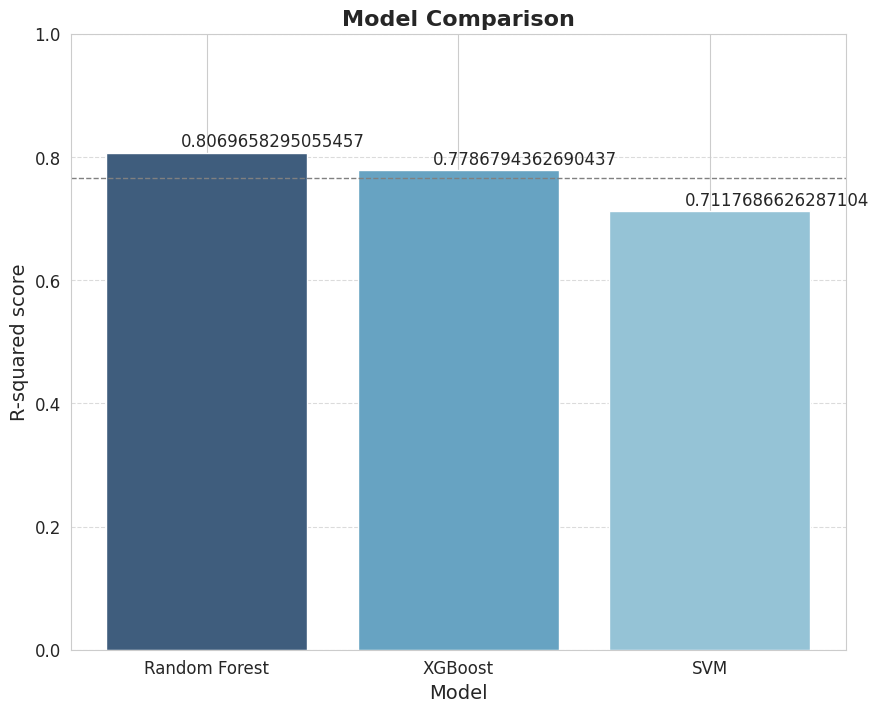

In [256]:
# Define the R-squared scores
scores = [rf.score(X_test, y_test), xgb_model.score(X_test, y_test), svm_model.score(X_test, y_test)]

# Define the models' names
models = ['Random Forest', 'XGBoost', 'SVM']

# Set the bar colors
colors = ['#3F5D7D', '#67A3C2', '#95C3D6']

# Create the bar plot
plt.figure(figsize=(10, 8))
plt.bar(models, scores, color=colors)
plt.title('Model Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Model', fontsize=14)
plt.ylabel('R-squared score', fontsize=14)

# Add the scores as labels on top of the bars
for i, v in enumerate(scores):
    print(type(v))
    plt.text(i - 0.1, v + 0.01, str(v), fontsize=12)

# Add a horizontal line for the average score
plt.axhline(y=sum(scores)/len(scores), color='gray', linestyle='--', linewidth=1)

# Customize the plot
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim([0, 1])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save and show the plot
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()